### The Mandelbrot Set Iteration

The Mandelbrot set is given as the iteration of the following equations
$$
z_{n+1} = z^2_n + c
$$

Where:
* $z_0$ = 0 (starting value)
* $c$ is a complex number, where each unique $c$ will yield a different sequence of $z$ values

A point $c$ is in the Mandelbort set if, after iterating the equation multiple times, $|z|$ (the magnitude of $Z$) stays bounded (specifically, it remains $\leq$ 2). If $|z|$ escapes beyond 2, $c$ is not part of the set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from multiprocessing import Pool
from worker import worker_function
from worker import worker_pure
from worker import worker_importance_orthogonal
from worker import worker_importance_random

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def mandelbrot(c_points, max_iter, escape_radius) -> tuple[np.array, np.array]:
    '''
    This function calculates the number of iterations until the magnitude of z escapes to infinity. 
    Within each iteration the z is updated with c, an imaginary number representing a grid point. 
    Ultimately, a mandelbrot is calculated. 
    '''
    iteration_count = np.zeros(c_points.shape)
    mandelbrot_set = np.zeros(c_points.shape, dtype=bool)
    for i in range(c_points.shape[0]):
        for j in range(c_points.shape[1]):

            # take a gridpoint
            c = c_points[i, j]
            z = 0
            for iteration in range(max_iter):

                # update of z
                z = z**2 + c
                if abs(z) > escape_radius:
                    mandelbrot_set[i, j] = False
                    iteration_count[i, j] =iteration
                    break
            else:
                mandelbrot_set[i, j] = True
                iteration_count[i, j] = max_iter
    return (mandelbrot_set, iteration_count)


            

#### Reading .txt file and processing data 

    grid_size  max_iterations      mean      variance
0         100              50  1.587400  3.235500e-05
1         100             500  1.514070  4.554900e-05
2         100            2000  1.509210  4.598100e-05
3         500              50  1.588313  8.924544e-07
4         500             500  1.514203  8.807040e-08
5         500            2000  1.508454  1.233360e-07
6        1000              50  1.588809  2.949309e-07
7        1000             500  1.514415  1.825290e-08
8        1000            2000  1.508635  1.250010e-08
9        5000              50  1.588611  6.961127e-09
10       5000             500  1.514234  1.166867e-09
11       5000            2000  1.508393  9.034790e-10


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17720\1244435819.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


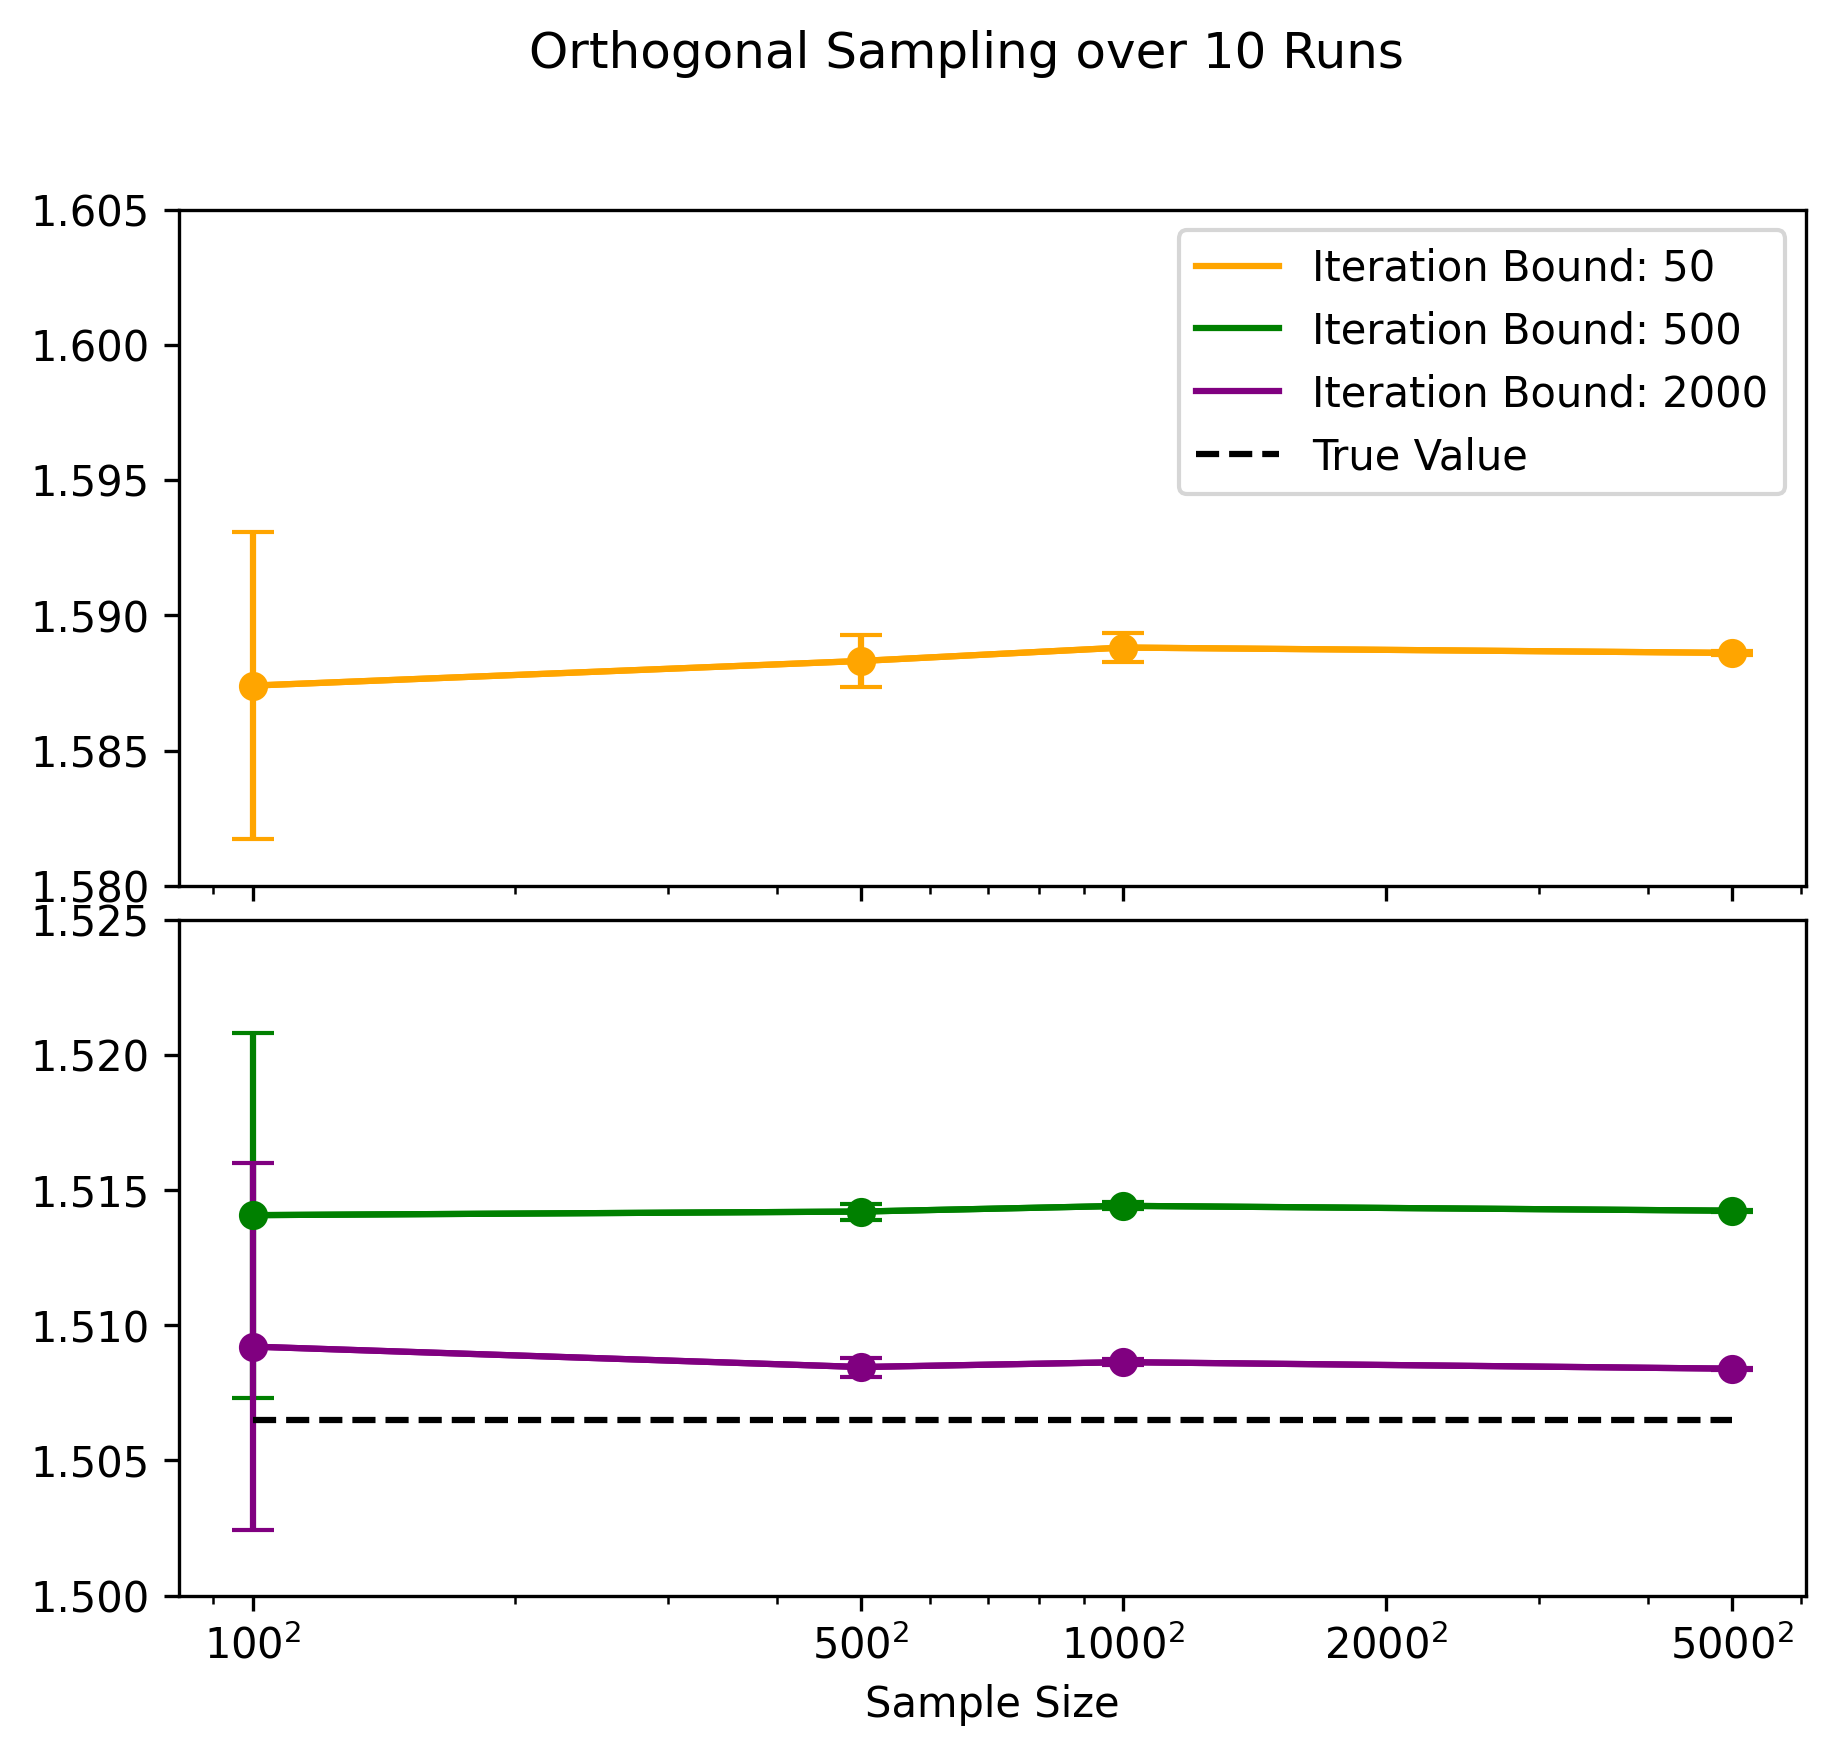

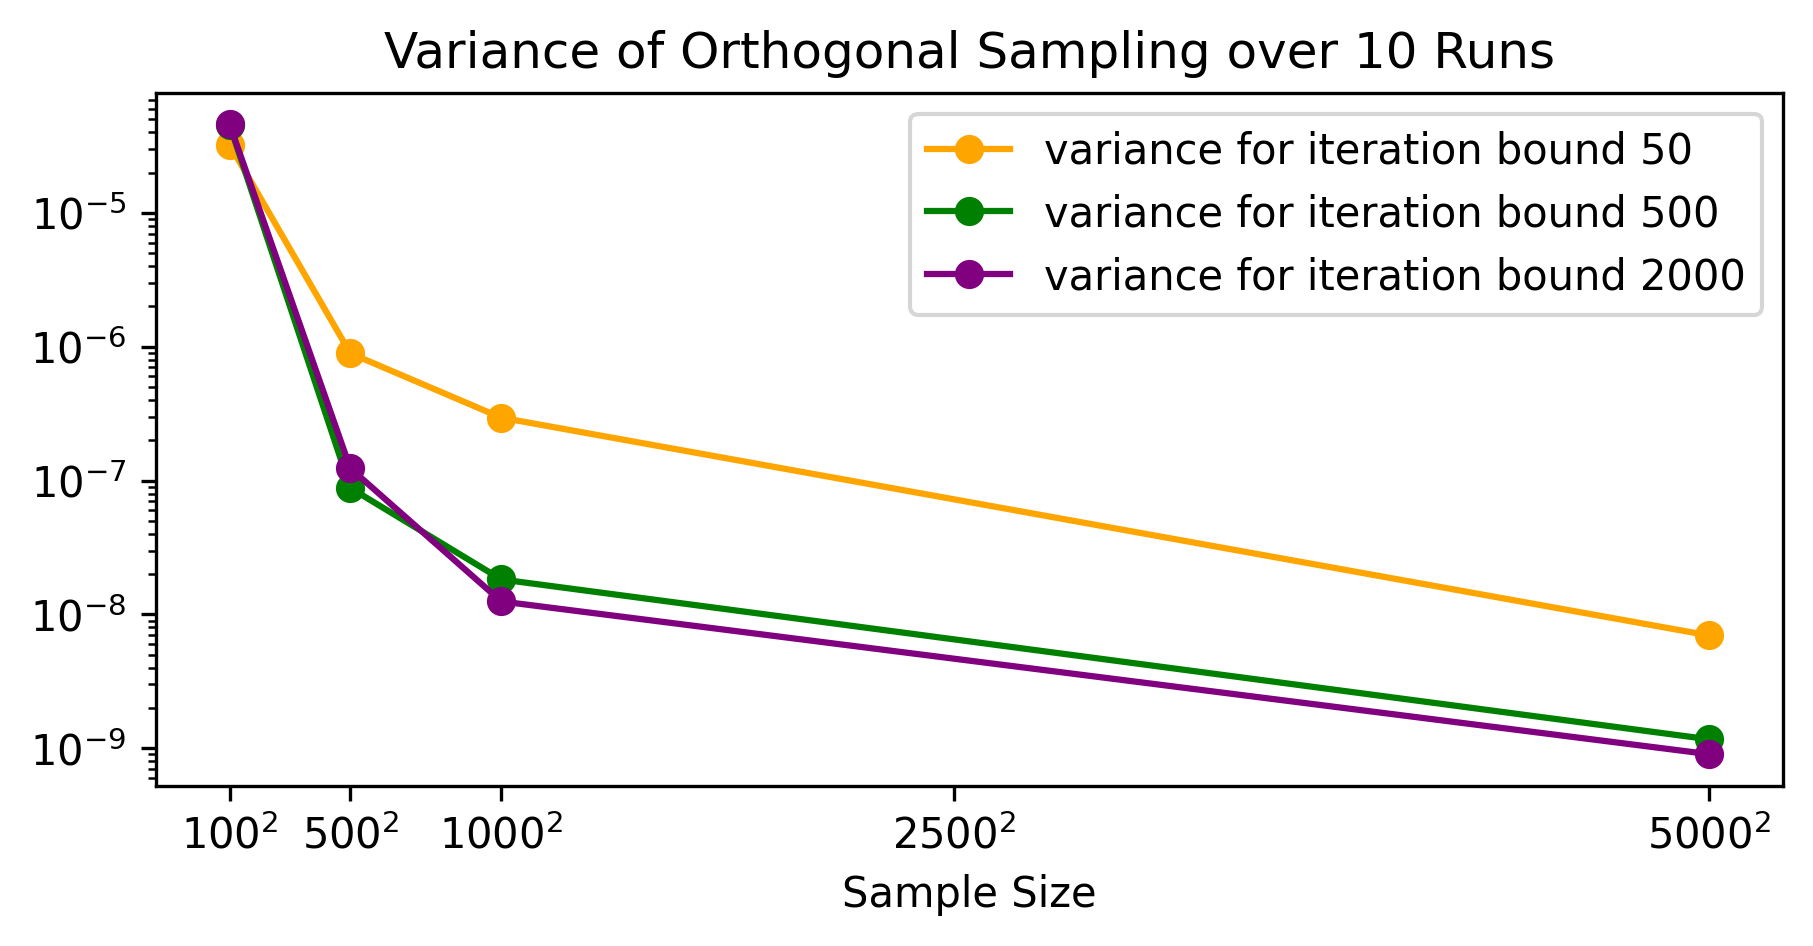

In [12]:
import pandas as pd
import seaborn as sns

df_o = pd.read_csv("orthogonal.txt", header=1)  # Set header=None since there is no header in the file

# Assign column labels
df_o.columns = ["grid_size", "max_iterations", "run", "total_points", "points_inside"]
df_o['fraction'] = (1- df_o['points_inside'] / df_o['total_points'])*9

average_fraction_o = df_o.groupby(['grid_size', 'max_iterations'])['fraction'].mean()
variance_fraction_o = df_o.groupby(['grid_size', 'max_iterations'])['fraction'].var()

mean_var_o = pd.DataFrame({
    'mean': average_fraction_o,
    'variance': variance_fraction_o
}).reset_index()
print(mean_var_o)

# df['grid_iterations'] = df['grid_size'].astype(str) + "_" + df['max_iterations'].astype(str)
# # Create boxplots for each metric
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='grid_iterations', y='fraction', data=df)
# plt.xlabel("Grid Size")
# plt.ylabel("Value")
# plt.title("Boxplot of Mean and Variance by Grid Size and Max Iterations")
# plt.legend(title="Metric")
# plt.ylim(1.49, 1.53)
# plt.xticks(rotation=45)
# plt.show()

colors = ["orange", "green", "purple"]
fig, (ax1, ax2) = plt.subplots(2,1, sharex= True, figsize=(7,6), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05}, dpi=300)
# bax = brokenaxes(ylims=((1.5, 1.525), (1.58, 1.595)), hspace=.05) 
i = 0
for name, group in mean_var_o.groupby("max_iterations"):
    ax1.plot(group['grid_size'], group['mean'], color=colors[i], label=f"Iteration Bound: {name}")
    ax1.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    # Plot on ax2 without labels to avoid duplicating in the legend
    ax2.plot(group['grid_size'], group['mean'], color=colors[i])
    ax2.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    i += 1

ax2.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.legend()
# ax2.legend()

ax1.set_ylim(1.58, 1.605)
ax2.set_ylim(1.5, 1.525)

# Set log scale on x-axis
ax1.set_xscale("log")
ax2.set_xscale("log")

custom_ticks = [100, 500, 1000, 2000, 5000]
ax2.set_xticks(custom_ticks)  # Set tick positions
ax2.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
ax2.set_xlabel("Sample Size")
fig.suptitle("Orthogonal Sampling over 10 Runs")
fig.tight_layout()
plt.show()

plt.figure(figsize=(7,3), dpi=300)
i = 0
for name, group in mean_var_o.groupby("max_iterations"):
    plt.plot(group["grid_size"], group['variance'], marker='o', color= colors[i],label = f'variance for iteration bound {name}')
    i+=1
plt.title("Variance of Orthogonal Sampling over 10 Runs")
custom_ticks = [100, 500, 1000, 2500, 5000]
ax =plt.gca()
ax.set_xticks(custom_ticks)  # Set tick positions
ax.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])

plt.xlabel("Sample Size")
plt.yscale("log")
plt.legend()
plt.show()

    grid_size  max_iterations      mean      variance
0         100              50  1.593400  6.783975e-04
1         100             500  1.515420  6.904440e-04
2         100            2000  1.509930  7.677090e-04
3         500              50  1.587283  3.076439e-05
4         500             500  1.512817  4.026126e-05
5         500            2000  1.506928  4.198967e-05
6        1000              50  1.588410  8.957826e-06
7        1000             500  1.514197  9.841670e-06
8        1000            2000  1.508302  1.079947e-05
9        5000              50  1.588519  1.286197e-07
10       5000             500  1.514108  1.964292e-07
11       5000            2000  1.508284  1.881114e-07


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17720\3801709209.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


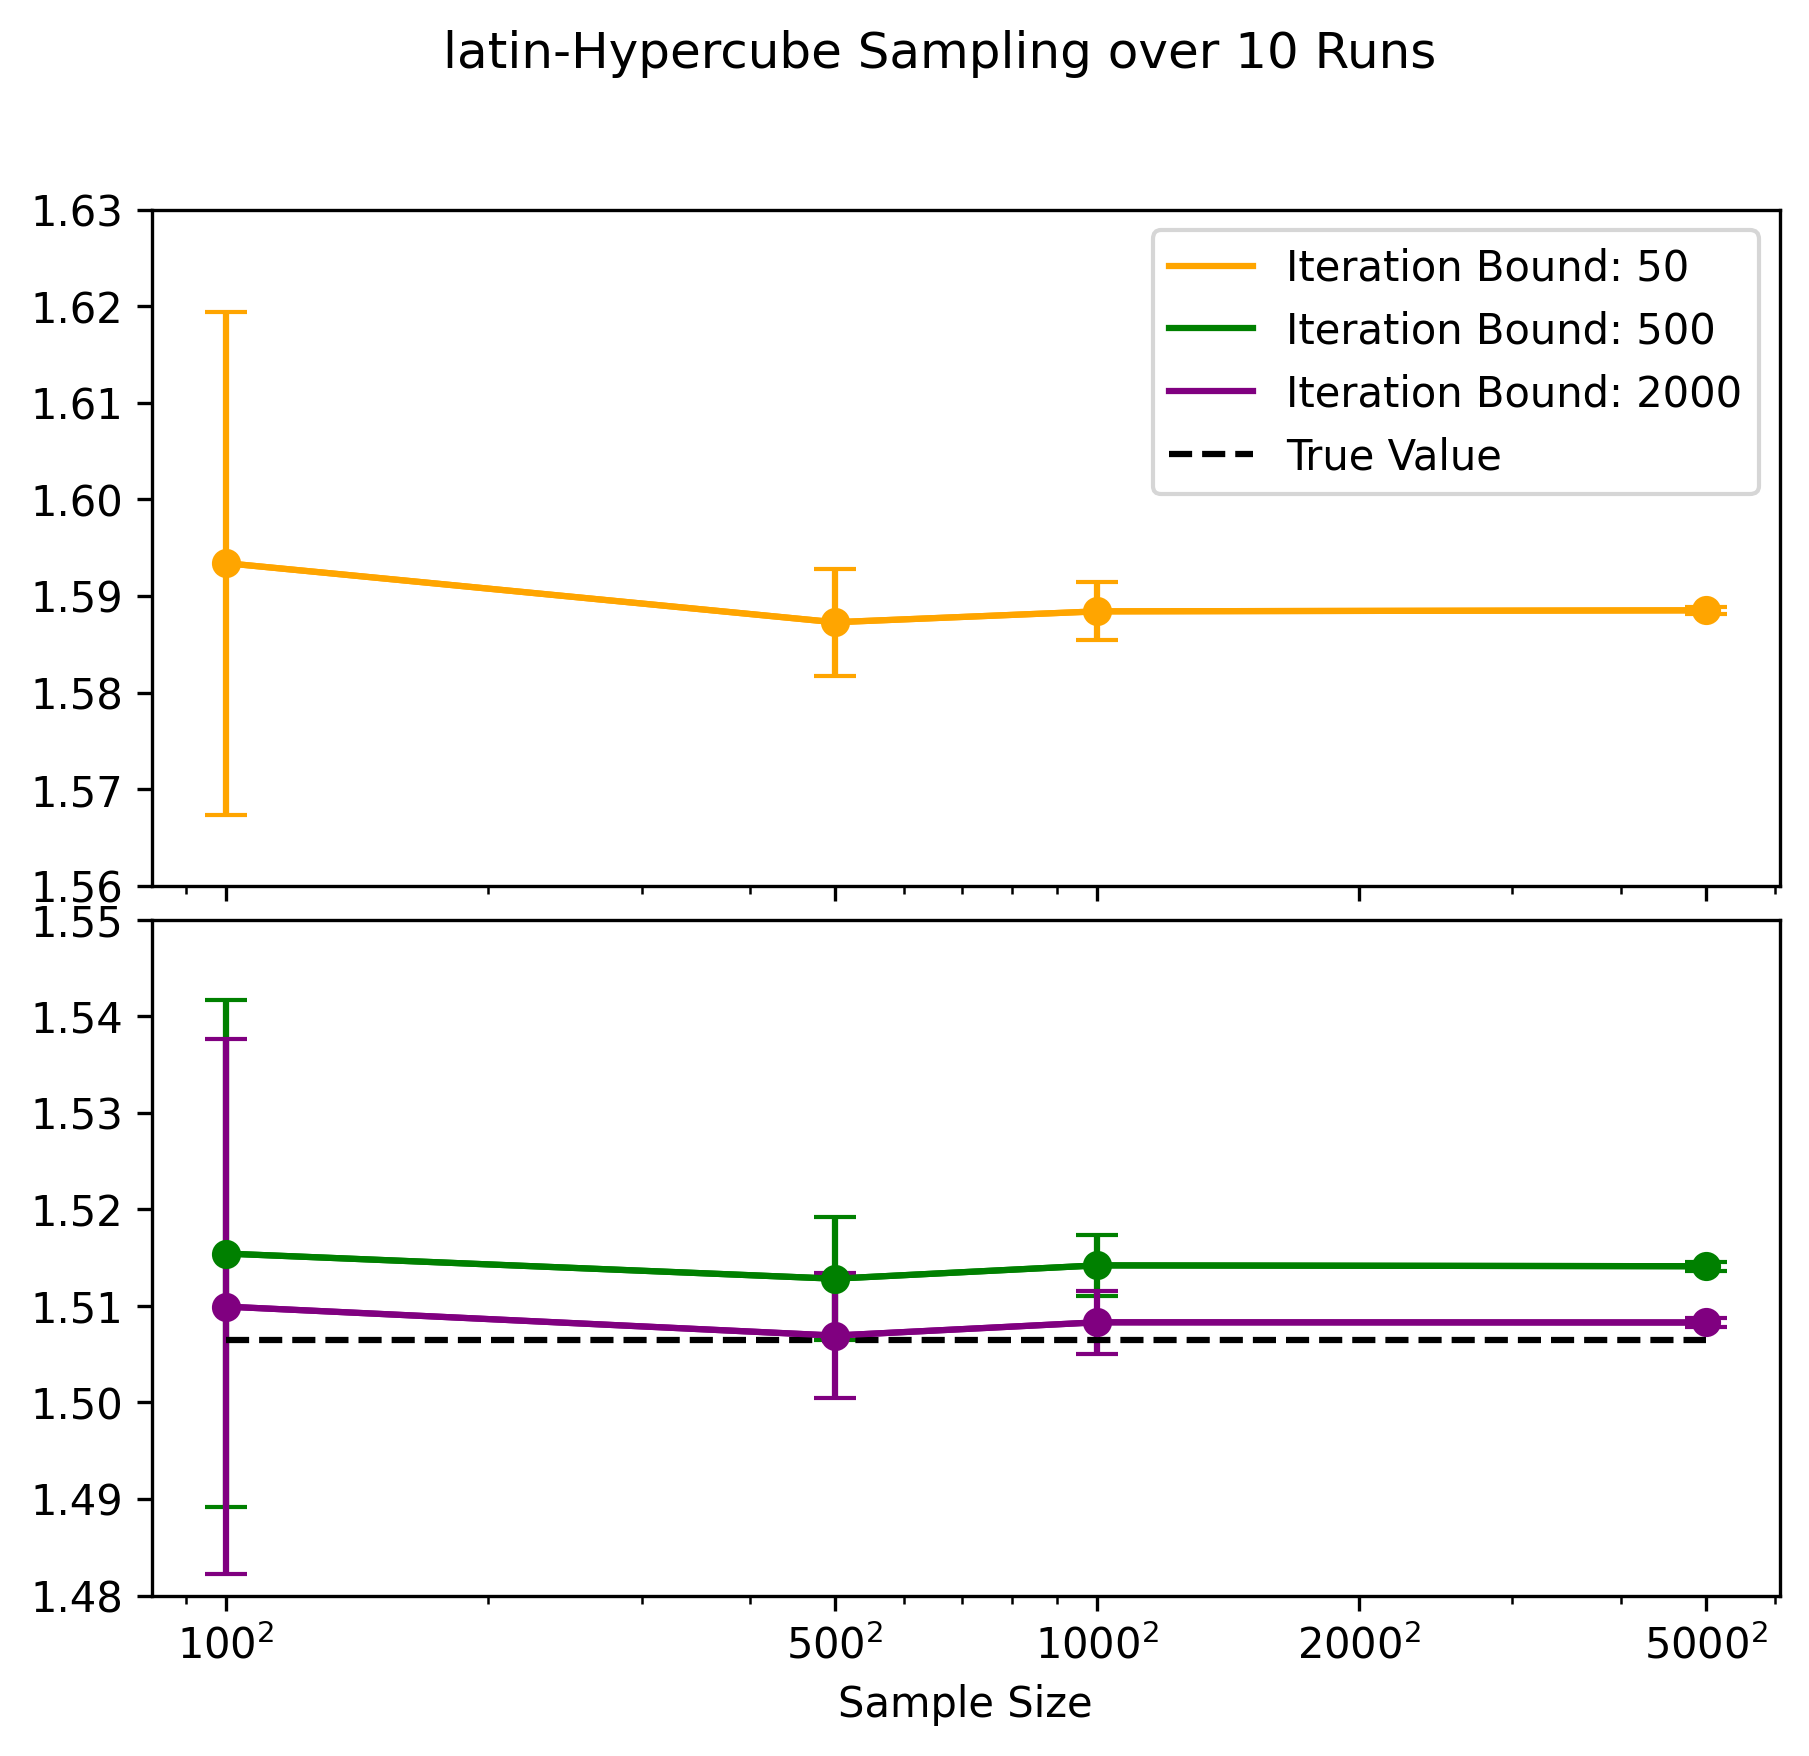

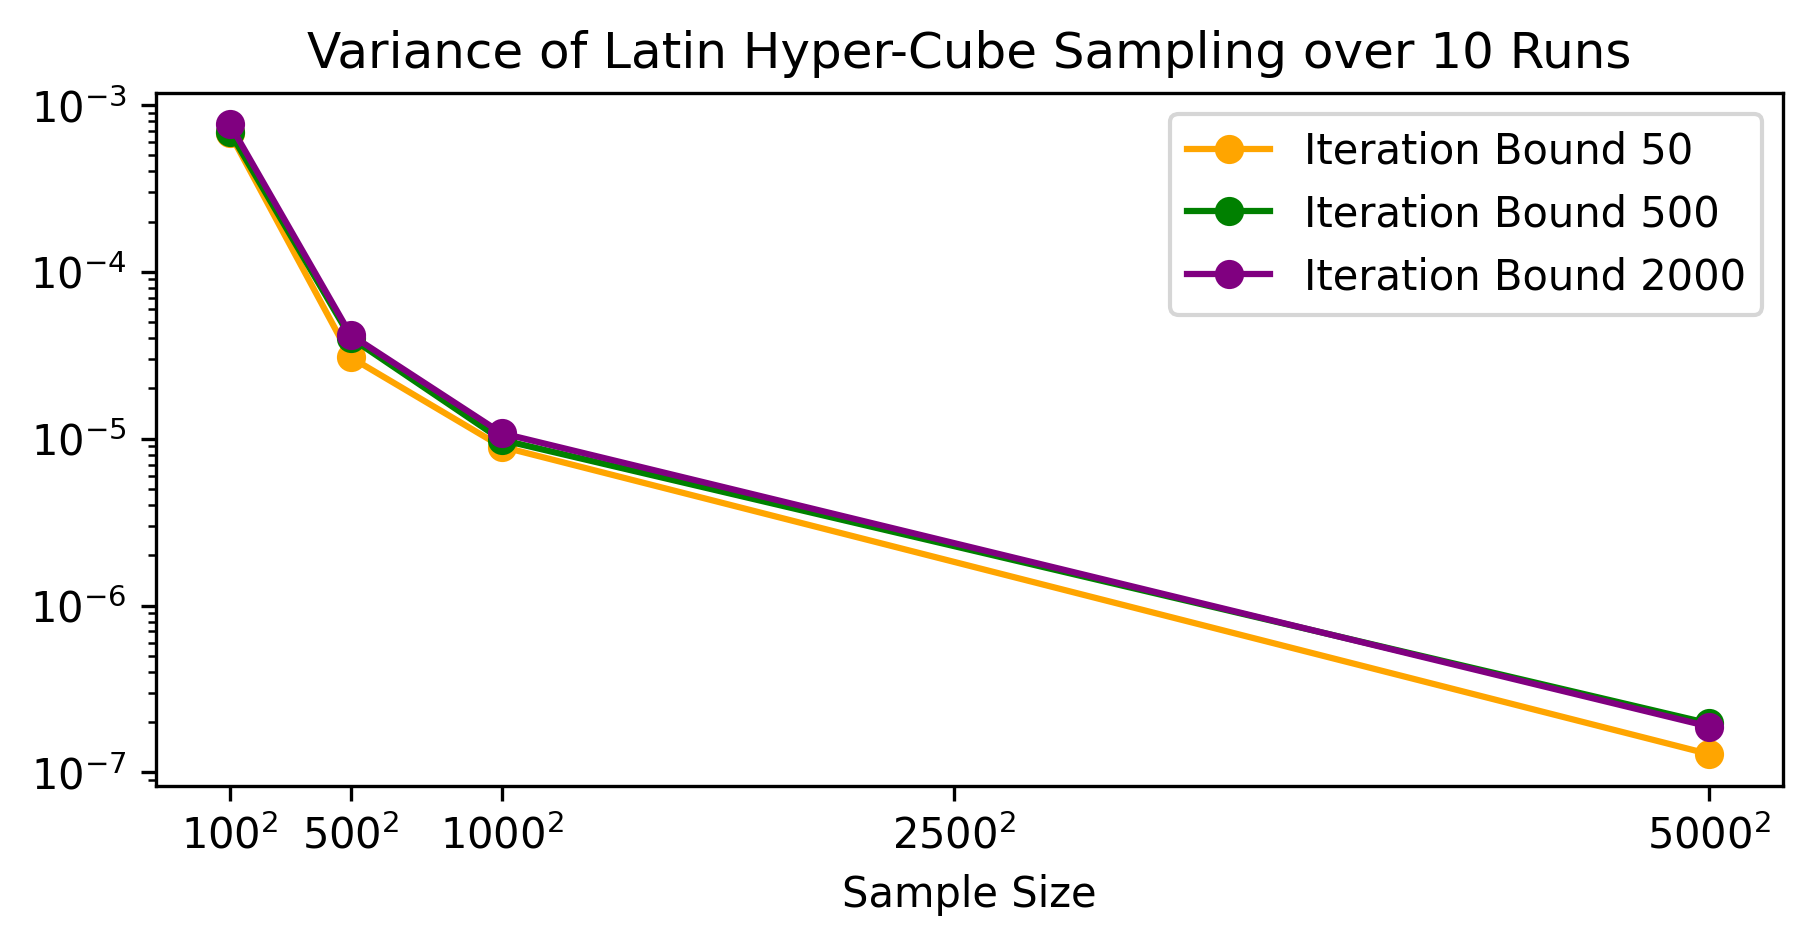

In [14]:
import pandas as pd
import seaborn as sns

df_l = pd.read_csv("latin.txt", header=1)  # Set header=None since there is no header in the file

# Assign column labels
df_l.columns = ["grid_size", "max_iterations", "run", "total_points", "points_inside"]
df_l['fraction'] = (1- df_l['points_inside'] / df_l['total_points'])*9

average_fraction = df_l.groupby(['grid_size', 'max_iterations'])['fraction'].mean()
variance_fraction = df_l.groupby(['grid_size', 'max_iterations'])['fraction'].var()

mean_var = pd.DataFrame({
    'mean': average_fraction,
    'variance': variance_fraction
}).reset_index()
print(mean_var)

colors = ["orange", "green", "purple"]
fig, (ax1, ax2) = plt.subplots(2,1, sharex= True, figsize=(7,6), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05}, dpi=300)
# bax = brokenaxes(ylims=((1.5, 1.525), (1.58, 1.595)), hspace=.05) 
i = 0
for name, group in mean_var.groupby("max_iterations"):
    ax1.plot(group['grid_size'], group['mean'], color=colors[i], label=f"Iteration Bound: {name}")
    ax1.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    # Plot on ax2 without labels to avoid duplicating in the legend
    ax2.plot(group['grid_size'], group['mean'], color=colors[i])
    ax2.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    i += 1

ax2.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax1.legend()
# ax2.legend()

ax1.set_ylim(1.56, 1.63)
ax2.set_ylim(1.48, 1.55)

# Set log scale on x-axis
ax1.set_xscale("log")
ax2.set_xscale("log")

custom_ticks = [100, 500, 1000, 2000, 5000]
ax2.set_xticks(custom_ticks)  # Set tick positions
ax2.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
ax2.set_xlabel("Sample Size")
fig.suptitle("latin-Hypercube Sampling over 10 Runs")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3), dpi=300)
i = 0
for name, group in mean_var.groupby("max_iterations"):
    plt.plot(group["grid_size"], group['variance'], marker='o', color= colors[i],label = f'Iteration Bound {name}')
    i+=1
plt.title("Variance of Latin Hyper-Cube Sampling over 10 Runs")

custom_ticks = [100, 500, 1000, 2500, 5000]
ax =plt.gca()
ax.set_xticks(custom_ticks)  # Set tick positions
ax.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
plt.xlabel("Sample Size")
plt.yscale("log")
plt.legend()
plt.show()

    grid_size  max_iterations      mean      variance
0         100              50  1.587700  7.689825e-04
1         100             500  1.517760  6.453360e-04
2         100            2000  1.511460  6.161040e-04
3         500              50  1.591276  2.079325e-05
4         500             500  1.517368  2.389599e-05
5         500            2000  1.511759  2.734746e-05
6        1000              50  1.588963  1.085669e-05
7        1000             500  1.514741  9.157184e-06
8        1000            2000  1.508863  8.259296e-06
9        5000              50  1.588817  1.622049e-07
10       5000             500  1.514445  1.921052e-07
11       5000            2000  1.508628  1.758043e-07
    grid_size  max_iterations      mean      variance
0         100              50  5.948000  7.689825e-04
1         100             500  5.691240  6.453360e-04
2         100            2000  5.665320  6.161040e-04
3         500              50  5.941879  2.079325e-05
4         500             50

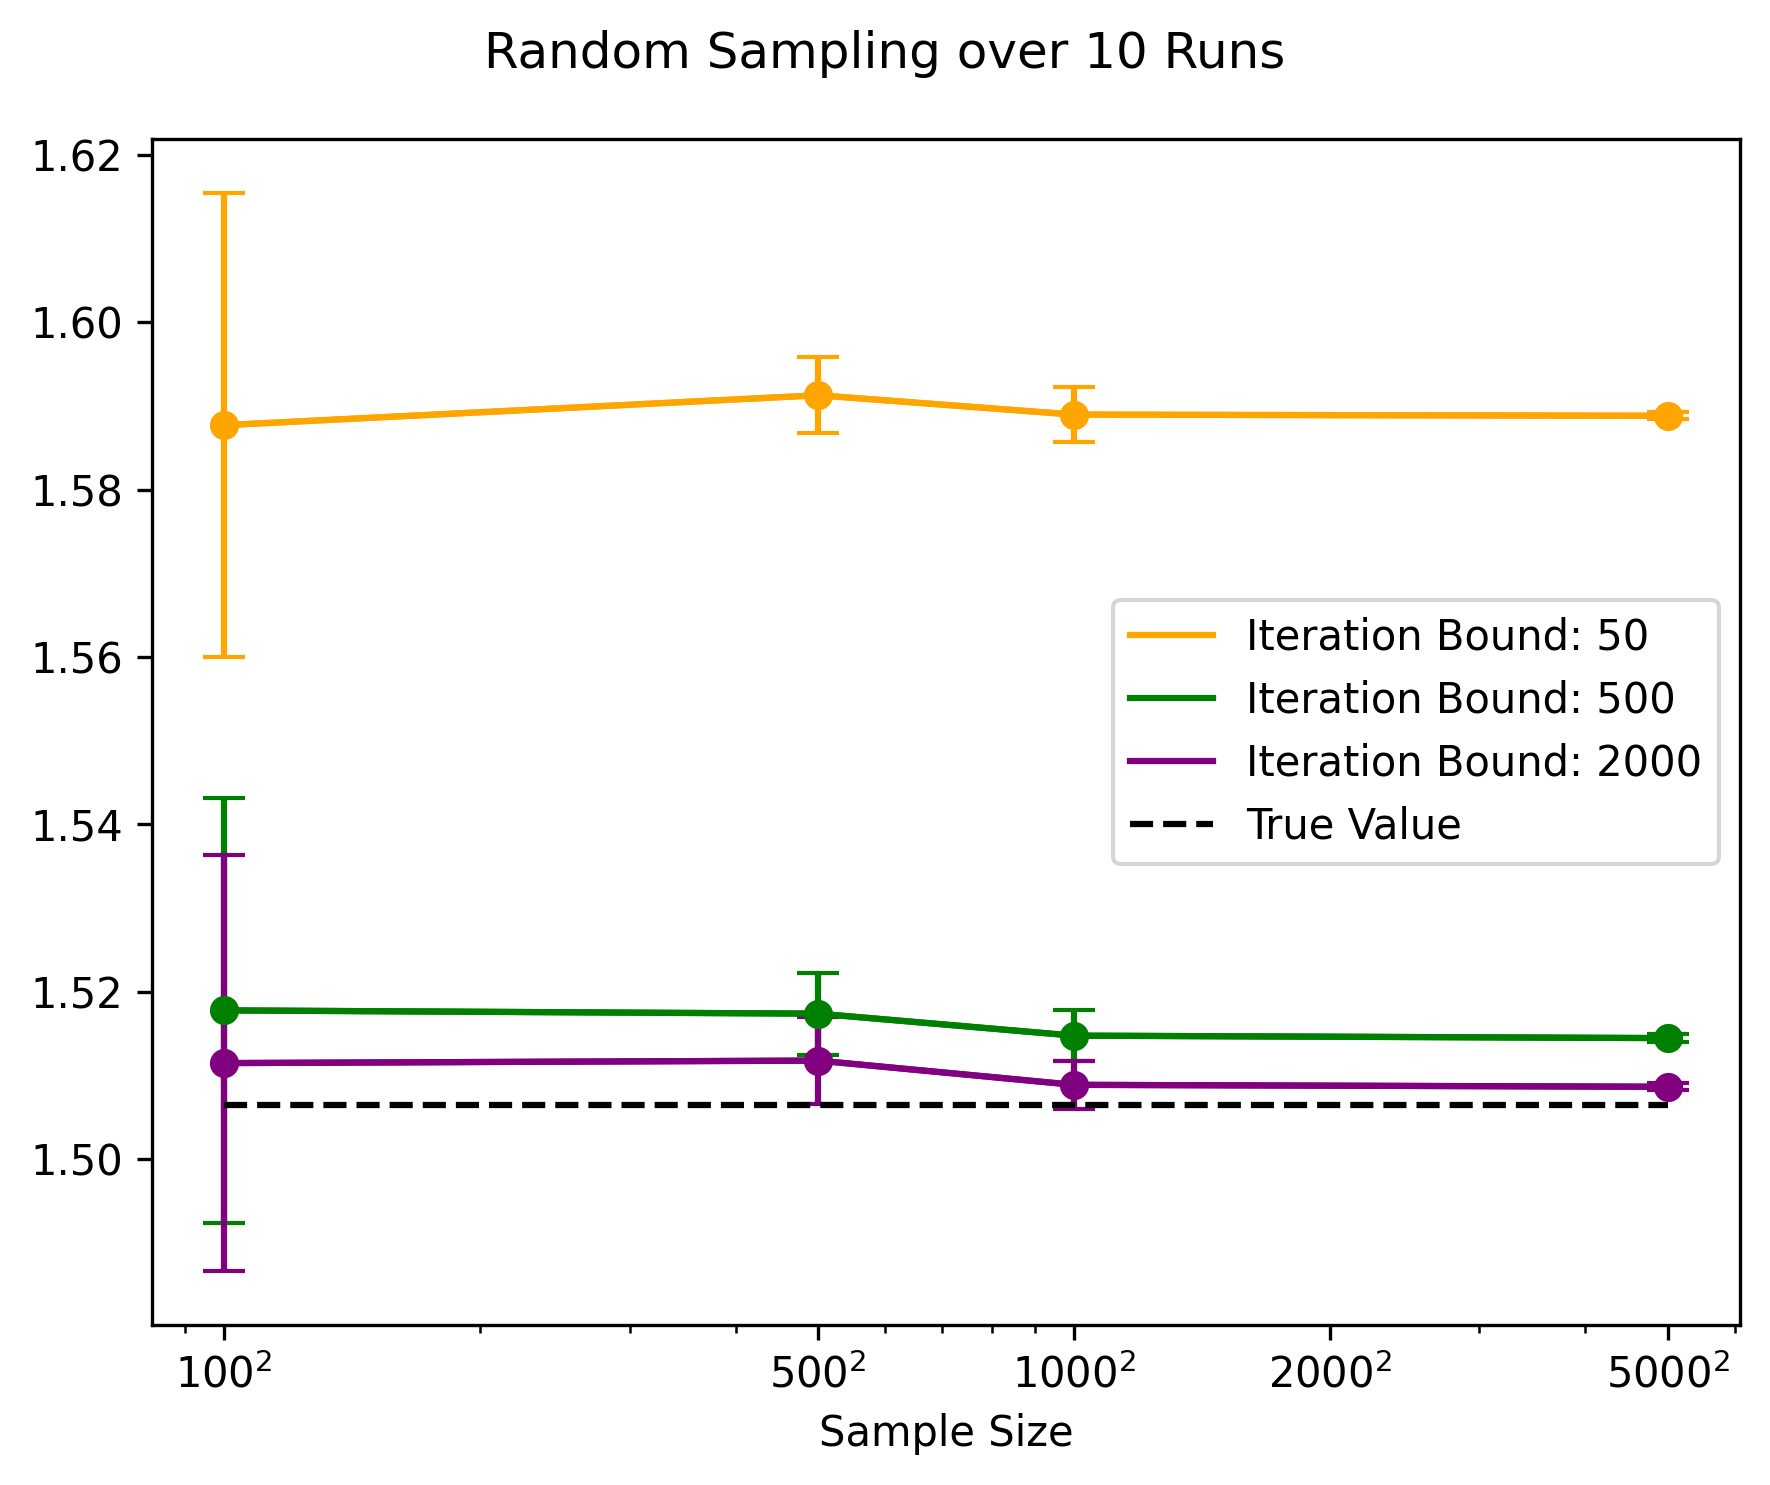

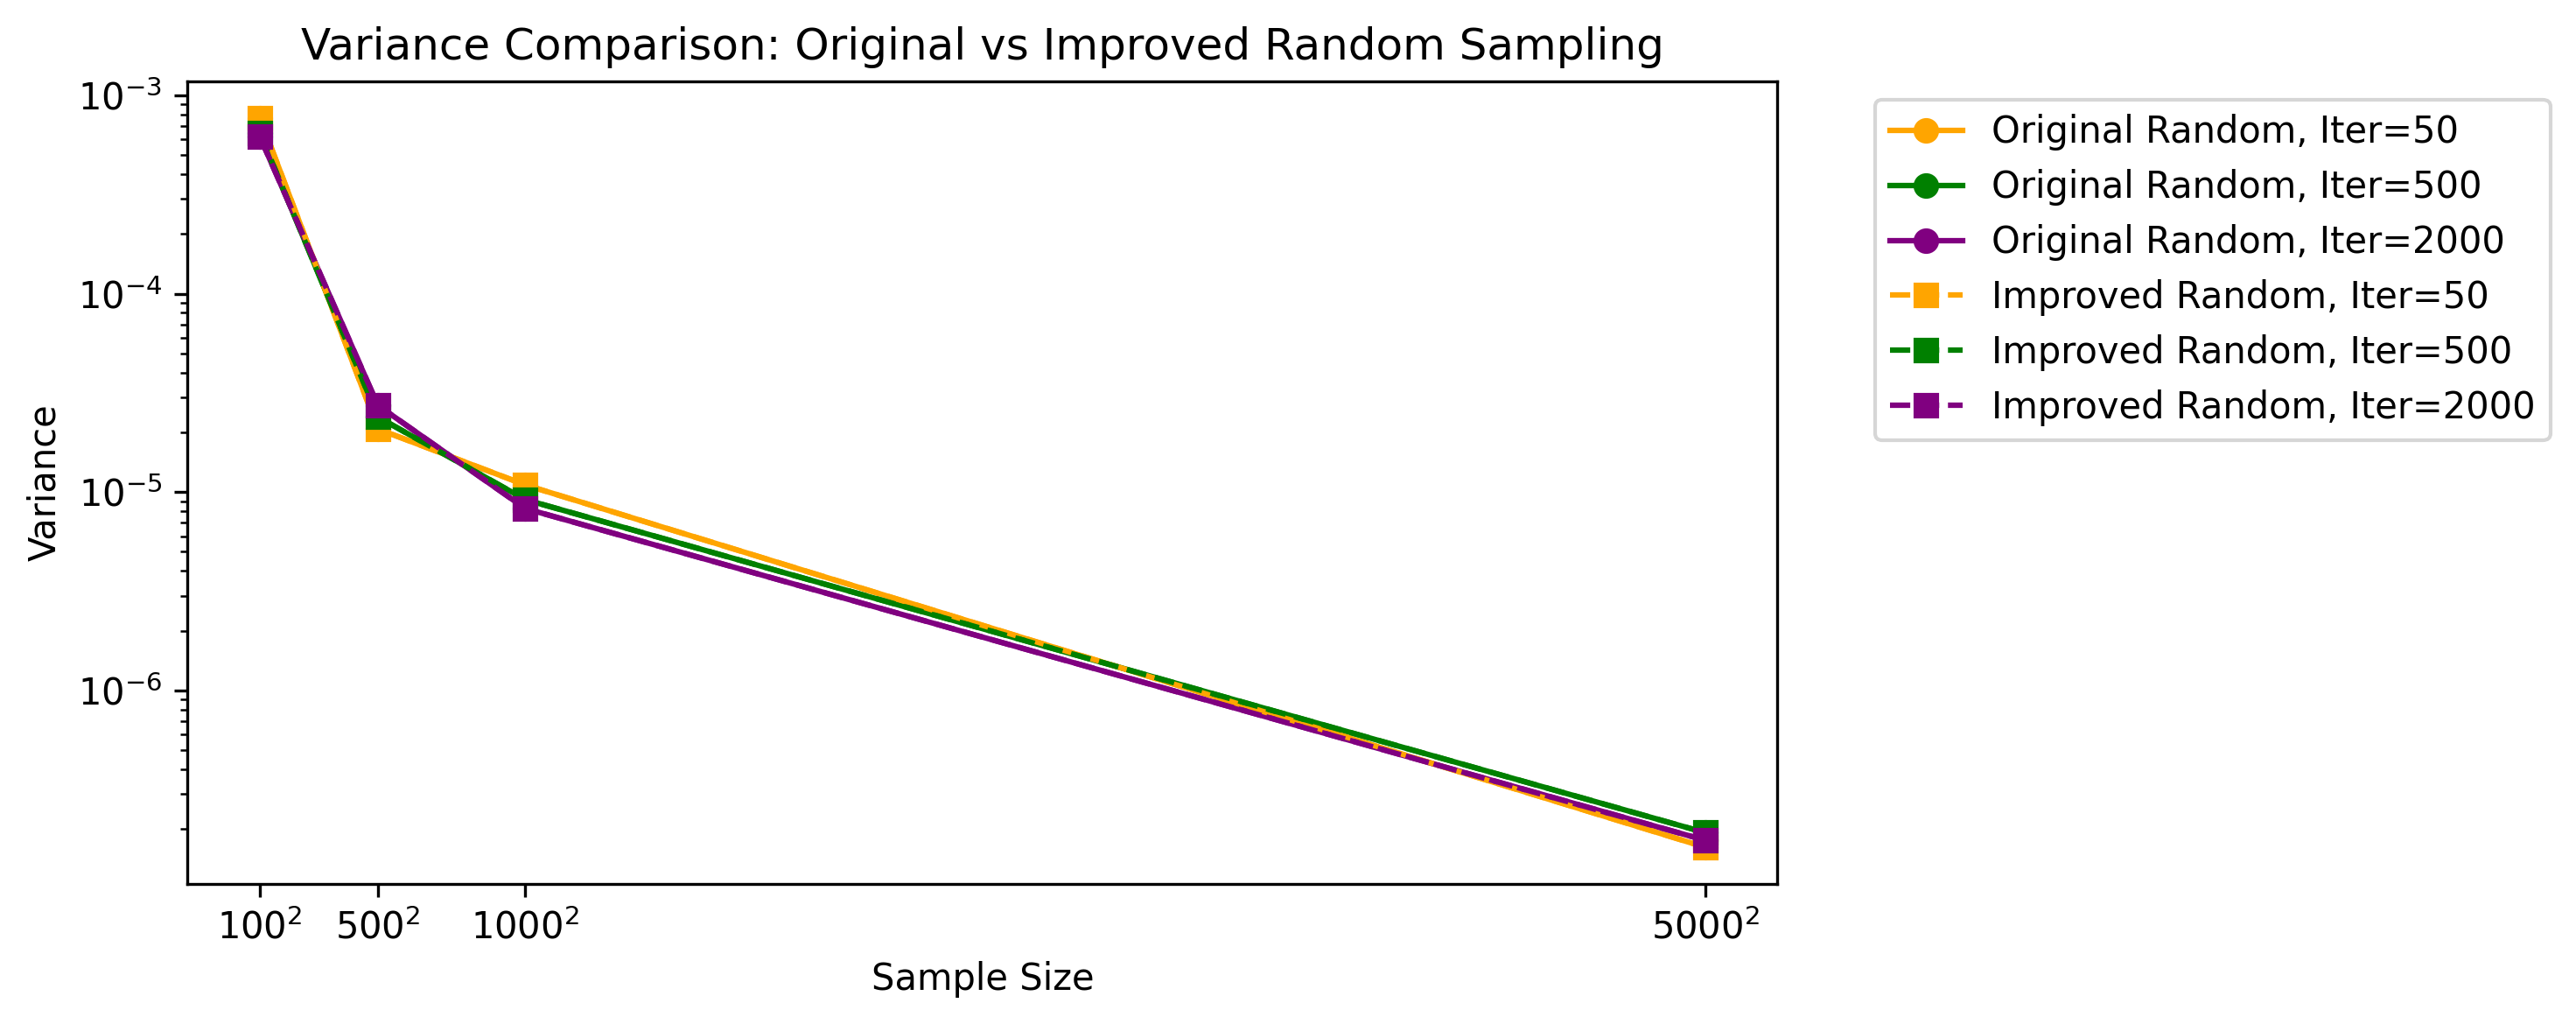

In [5]:
import pandas as pd
import seaborn as sns

df_r = pd.read_csv("random.txt", header=1)  # Set header=None since there is no header in the file
df_imp_r = pd.read_csv('improved_random_sampling.txt', header=1)

# Assign column labels
df_r.columns = ["grid_size", "max_iterations", "run", "total_points", "points_inside"]
df_r['fraction'] = (1- df_r['points_inside'] / df_r['total_points'])*9
df_imp_r.columns = ['grid_size', 'max_iterations', 'run', 'total_points', 'points_inside']
df_imp_r['fraction'] = (1 - df_imp_r['points_inside'] / df_imp_r['total_points']) * 9

average_fraction = df_r.groupby(['grid_size', 'max_iterations'])['fraction'].mean()
variance_fraction = df_r.groupby(['grid_size', 'max_iterations'])['fraction'].var()
average_imp_fraction = df_imp_r.groupby(['grid_size', 'max_iterations'])['fraction'].mean()
variance_fraction = df_imp_r.groupby(['grid_size', 'max_iterations'])['fraction'].var()

mean_var = pd.DataFrame({
    'mean': average_fraction,
    'variance': variance_fraction
}).reset_index()
print(mean_var)

mean_imp_var = pd.DataFrame({
    'mean': average_imp_fraction,
    'variance':variance_fraction
}).reset_index()
print(mean_imp_var)

colors = ["orange", "green", "purple"]
fig, ax = plt.subplots(1,1, sharex= True, figsize=(6,5), dpi=300)
# bax = brokenaxes(ylims=((1.5, 1.525), (1.58, 1.595)), hspace=.05) 
i = 0
for name, group in mean_var.groupby("max_iterations"):
    ax.plot(group['grid_size'], group['mean'], color=colors[i], label=f"Iteration Bound: {name}")
    ax.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    # # Plot on ax2 without labels to avoid duplicating in the legend
    # ax2.plot(group['grid_size'], group['mean'], color=colors[i])
    # ax2.errorbar(group['grid_size'], group["mean"], yerr=np.sqrt(group['variance']), fmt='o-', color=colors[i], capsize=5)

    i += 1

ax.plot(group['grid_size'], [1.506484]*4, color='black', linestyle= '--', label='True Value')
ax.legend()


# ax1.set_ylim(1.56, 1.63)
# ax2.set_ylim(1.48, 1.55)

# Set log scale on x-axis
ax.set_xscale("log")


custom_ticks = [100, 500, 1000, 2000, 5000]
ax.set_xticks(custom_ticks)  # Set tick positions
ax.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
ax.set_xlabel("Sample Size")
fig.suptitle("Random Sampling over 10 Runs")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4), dpi=300)

# Plot original random sampling
for i, (name, group) in enumerate(mean_var.groupby("max_iterations")):
    plt.plot(group["grid_size"], group['variance'], 
             marker='o', 
             color=colors[i], 
             label=f'Original Random, Iter={name}',
             linestyle='-')

# Plot improved random sampling
for i, (name, group) in enumerate(mean_imp_var.groupby("max_iterations")):
    plt.plot(group["grid_size"], group['variance'], 
             marker='s',  # Different marker for improved method
             color=colors[i], 
             label=f'Improved Random, Iter={name}',
             linestyle='--')  # Dashed line for improved method

plt.title("Variance Comparison: Original vs Improved Random Sampling")

custom_ticks = [100, 500, 1000, 5000]
ax = plt.gca()
ax.set_xticks(custom_ticks)
ax.set_xticklabels([f"${tick}^2$" for tick in custom_ticks])

plt.xlabel("Sample Size")
plt.ylabel("Variance")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()  # Adjust layout to prevent legend cutoff
plt.show()

    index  grid_size  max_iterations  total_points  points_inside  fraction  \
0      18        100              10         10000           7794  1.985400   
1      19        100              20         10000           8124  1.688400   
2      20        100              50         10000           8262  1.564200   
3      21        100             100         10000           8302  1.528200   
4      22        100             150         10000           8314  1.517400   
5      23        100             250         10000           8334  1.499400   
6      24        100             500         10000           8340  1.494000   
7      25        100            1000         10000           8342  1.492200   
8      26        100            2000         10000           8342  1.492200   
9      36        500              10        250000         193984  2.016576   
10     37        500              20        250000         202106  1.724184   
11     38        500              50        250000  

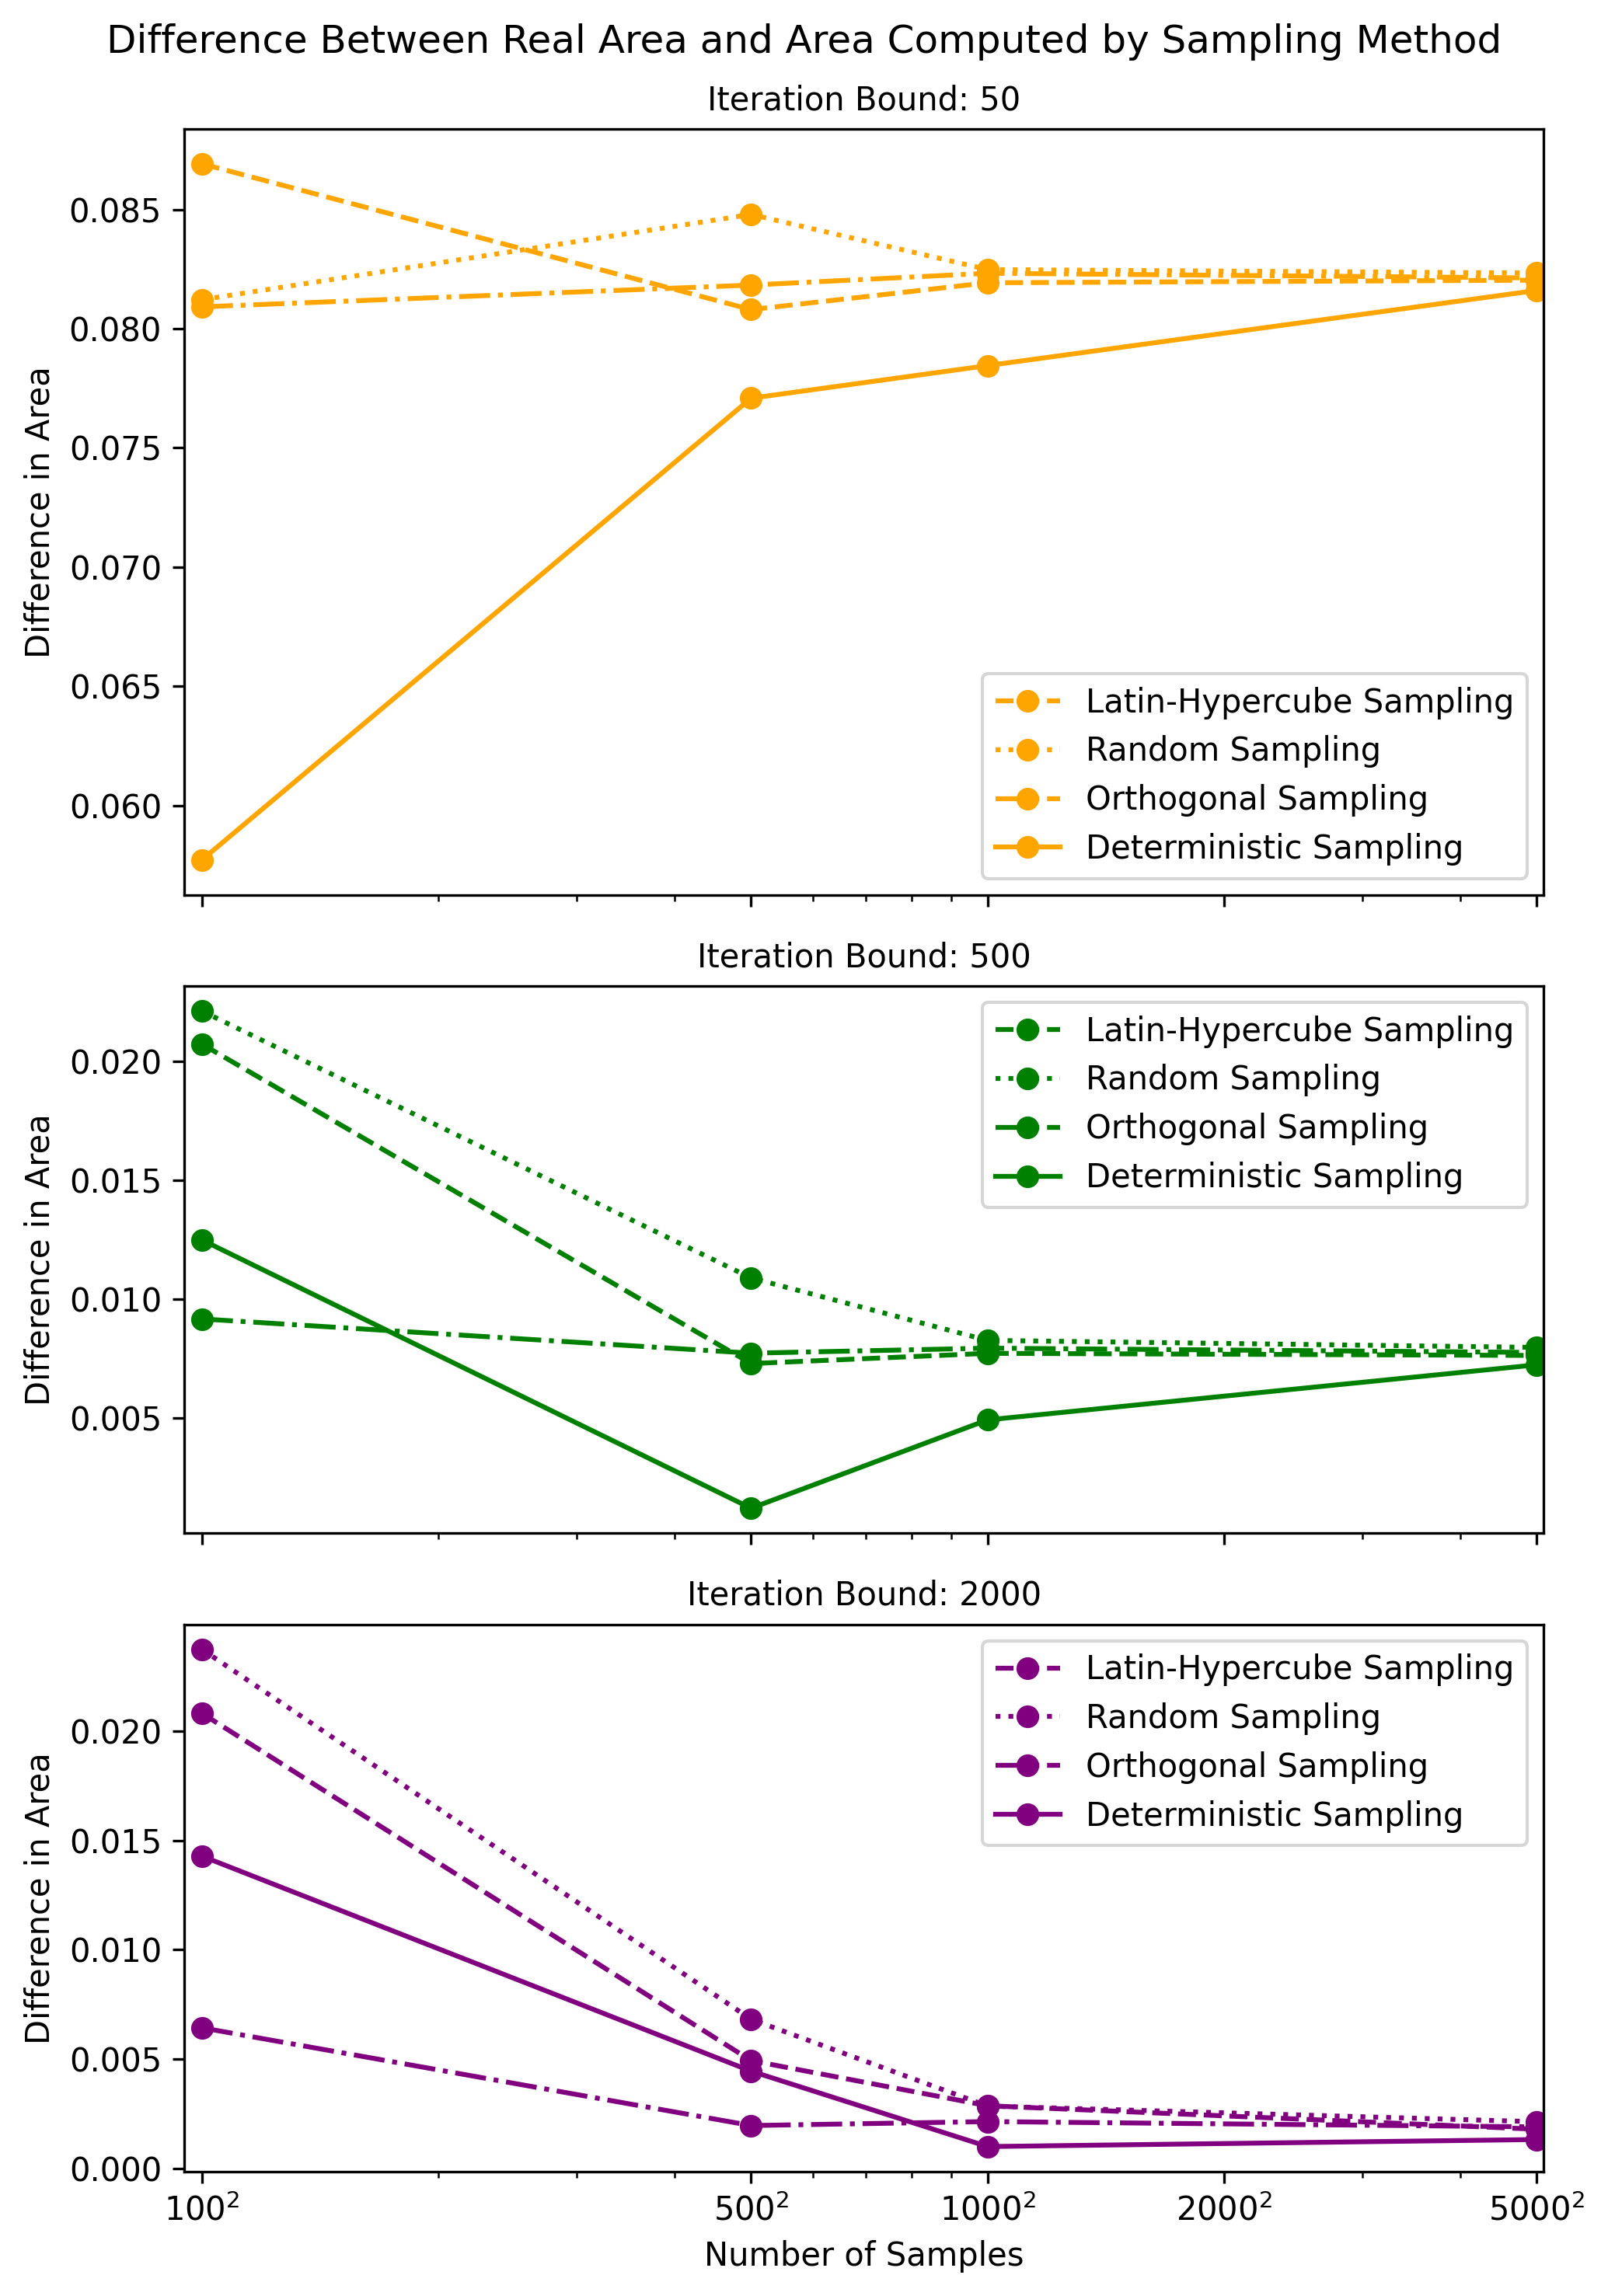

In [10]:
df = pd.read_csv("question2.txt", delimiter=",", skiprows=1,
                 names=["grid_size", "max_iterations", "total_points", "points_inside"])
df["fraction"] = (1 - df["points_inside"]/df["total_points"])*9
true_value = [1.506484]*len(df['fraction'])
df["diff_true"] = np.abs(true_value-df['fraction'])


true_value = [1.506484]*len(df_l['fraction'])
df_l["diff_true"] = np.abs(true_value-df_l['fraction'])
average_diff_l = df_l.groupby(['grid_size', 'max_iterations'])['diff_true'].mean()
variance_diff_l = df_l.groupby(['grid_size', 'max_iterations'])['diff_true'].var()


true_value = [1.506484]*len(df_o['fraction'])
df_o["diff_true"] = np.abs(true_value-df_o['fraction'])

average_diff_o = df_o.groupby(['grid_size', 'max_iterations'])['diff_true'].mean()
variance_diff_o = df_o.groupby(['grid_size', 'max_iterations'])['diff_true'].var()

true_value = [1.506484]*len(df_r['fraction'])
df_r["diff_true"] = np.abs(true_value-df_r['fraction'])

average_diff_r = df_r.groupby(['grid_size', 'max_iterations'])['diff_true'].mean()
variance_diff_r = df_r.groupby(['grid_size', 'max_iterations'])['diff_true'].var()

mean_var_diff = pd.DataFrame({
    'mean_o': average_diff_o,
    'variance_o': variance_diff_o,
    'mean_l': average_diff_l,
    'variance_l': variance_diff_l, 
    'mean_r': average_diff_r,
    'variance_r': variance_diff_r
}).reset_index()



grid_sizes = [100, 500, 1000, 5000]
grid_sub_df = df[(df['grid_size'].isin(grid_sizes))].reset_index()
print(grid_sub_df)

fig, axes = plt.subplots(3, 1,sharex=True,figsize=(7,10), gridspec_kw={'height_ratios': [1.4, 1, 1]}, dpi=300)
i = 0
for name, group in mean_var_diff.groupby("max_iterations"):
    ax = axes[i]
    ax.plot(group['grid_size'], group['mean_l'], marker='o', color=colors[i], linestyle='--', label=f"Latin-Hypercube Sampling")
    # ax.errorbar(group['grid_size'], group["mean_l"], yerr=np.sqrt(group['variance_l']), fmt='o', color=colors[i], capsize=5)

    ax.plot(group['grid_size'], group['mean_r'], marker='o', color=colors[i], linestyle=':', label=f"Random Sampling")
    # ax.errorbar(group['grid_size'], group["mean_r"], yerr=np.sqrt(group['variance_l']), fmt='o', color=colors[i], capsize=5)

    ax.plot(group['grid_size'], group['mean_o'], marker='o', color=colors[i], linestyle='-.', label=f"Orthogonal Sampling")
    # ax.errorbar(group['grid_size'], group["mean_o"], yerr=np.sqrt(group['variance_o']), fmt='o', color=colors[i], capsize=5)

    deterministic_val= grid_sub_df[grid_sub_df["max_iterations"] == name]
    print(deterministic_val)
    ax.plot(group['grid_size'], deterministic_val['diff_true'], marker='o', color=colors[i], label='Deterministic Sampling')

    ax.set_xscale("log")
    ax.set_ylabel("Difference in Area")
    ax.set_title(f"Iteration Bound: {name}", fontsize=10)
    ax.legend()
    i += 1

axes[2].set_xlim(95, 5100)
custom_ticks = [100, 500, 1000, 2000, 5000]
axes[2].set_xticks(custom_ticks)  # Set tick positions
axes[2].set_xticklabels([f"${tick}^2$" for tick in custom_ticks])
axes[2].set_xlabel("Number of Samples")
fig.suptitle("Difference Between Real Area and Area Computed by Sampling Method")
plt.tight_layout()
plt.show()

#### Framework for Parallelized implementation -> for all sampling
Do not forget to add sampling specific code in the worker.py file, and add parameters underneath.   
Code is currently running with deterministic function mandelbrot in worker.py. Idea is to replace this function (do not remove mandelbrot tho) with sampling specific function.  
Also, in case of changes in worker.py, reload this module, such that notebook refreshes imports and notices changes.  

Copy this cell, to keep this framework reusable


In [ ]:
import os
from multiprocessing import Pool
# Import own fucntion from .py file -> write for own sampling method! parameters of this function = grid (already given), max iteration bound (already given), sampling specific parameters (need to be difined still)
# Don't forget to also return the parameter values (as specified in example worker function)
from worker import worker_function


def partition_func(pars):

    # max 10 processes
    PROCESSES = 10 
    dict_res = {}
    with Pool(PROCESSES) as pool:  # Adjust the number of processes as needed 
        results = pool.map(worker_function,  pars)
        for res in results:
            (tot_points, out_points), par = res
            dict_res[par] = (tot_points, out_points)
            print(f"Gridsize: {par[0]}, Iteration Bound:{par[1]}\nTotal points and points inside mandelbrot: {tot_points, out_points}")
    return dict_res

if __name__ == '__main__':
    # Specify the s_values and grid sizes you want to experiment with
    # add sampling specific parameters, which are used in the worker method. (such as number of random samples taken (suggestion: choose 3 values for this, low, med, high))
    # evaluate when stochastic method is better than deterministic one. 
    
    # These are the values to experiment with, test with dummy values (these are quicker)
    s_values = [50, 500, 2000]
    grids = [100, 1000, 5000]
    # sampling_specific = [x, y, z]

    # Dummy values
    # s_values = [10, 50, 60, 70]
    # grids = [10, 50, 100, 150]

    par_combos = []

    # every proc gets a full grid, every proc a different parameter set (defined above)
    # add an extra for loop for an extra parameter
    for g in grids:
        real = np.linspace(-2.0, 1.0, g)
        imag = np.linspace(-1.5, 1.5, g)
        real_grid, imag_grid = np.meshgrid(real, imag)
        c_points = real_grid + 1j * imag_grid
        for s in s_values:
            par_combos.append((c_points, g, s))
    saved_values = {}
    # make sure the number of procs you use does not exceed the processor count

    print(f"Number of available CPU cores: {os.cpu_count()}")
    for i in range(10):
        # provide random seed such that random function will be different
        random_seed = i+42
        par_combos = [(comb, random_seed) for comb in par_combos]
        saved_values = partition_func(par_combos)

        # ensure saving the values with this code:
        # CHANGE FILE NAME!!
        with open("question3-1.txt", "w") as file:
            # add parameter in case a parameter is added to the 
            if i == 0:
                file.write("grid_size, max_iterations, total_points, points_inside\n")
            file.write(f"run {i}:")
            for (key1, key2), (value1, value2)  in saved_values.items():
                file.write(f"{key1}, {key2}, {value1}, {value2}\n")


#Since the mandelbrot is symmetrical, we could halve the grid and get the same fraction 

#### Orthongonal Sampling

In [ ]:
import os
from multiprocessing import Pool
# Import own fucntion from .py file -> write for own sampling method! parameters of this function = grid (already given), max iteration bound (already given), sampling specific parameters (need to be difined still)
# Don't forget to also return the parameter values (as specified in example worker function)

import sys
from worker import worker_function_sampling
from worker import worker_orthogonal



def partition_func(pars):

    # max 10 processes
    PROCESSES = 10 
    dict_res = {}
    with Pool(PROCESSES) as pool:  # Adjust the number of processes as needed 
        print("Starting parallel execution")
        for res in pool.imap_unordered(worker_orthogonal,  pars):
            (tot_points, out_points), par = res
            dict_res[par] = (tot_points, out_points)
            print(f"Gridsize: {par[0]}, Iteration Bound:{par[1]}, Run: {par[2]}\n Total points and points inside mandelbrot: {tot_points, out_points}", flush=True)
    return dict_res

if __name__ == '__main__':
    # Specify the s_values and grid sizes you want to experiment with
    # add sampling specific parameters, which are used in the worker method. (such as number of random samples taken (suggestion: choose 3 values for this, low, med, high))
    # evaluate when stochastic method is better than deterministic one. 
    
    # These are the values to experiment with, test with dummy values (these are quicker)
    s_values = [50, 500, 2000]
    # grids need to be prime numbers for orthogonal to work
    grids = [100, 500, 1000, 5000]
    # primes_grids = [101, 503, 997]
    # sampling_specific = [x, y, z]

    # Dummy values
    # s_values = [10, 50, 60, 70]
    # primes_grids = [7, 31, 71, 101, 317]  #the square of these values is approx. [50, 500, 5000, 10000,  100 000]
    par_combos = []
    # sys.stdout = os.fdopen(sys.stdout.fileno(), 'w', buffering=1)
    # make sure the number of procs you use does not exceed the processor count

    
    print(f"Number of available CPU cores: {os.cpu_count()}")
    
    # 10 runs
    for i in range(10):
        # provide random seed such that random function will be different
        random_seed = i+42

        # every proc gets a full grid, every proc a different parameter set (defined above)
        # add an extra for loop for an extra parameter
        for g in grids:
            
            # print(c_points)
            for s in s_values:
                par_combos.append( (g, s, i, random_seed))

    saved_values = {}
    saved_values = partition_func(par_combos)

    # ensure saving the values with this code:
    # CHANGE FILE NAME!!
    with open("orthogonal.txt", "w") as file:
        # add parameter in case a parameter is added to the 
        file.write("grid_size, max_iterations, run, total_points, points_inside\n")
        for (key1, key2, run), (value1, value2)  in saved_values.items():
            file.write(f"{key1}, {key2}, {run}, {value1}, {value2}\n")


#Since the mandelbrot is symmetrical, we could halve the grid and get the same fraction 

In [4]:
# grid_size = np.linspace(4, )
import os
from multiprocessing import Pool
from worker import worker_function

def partition_grid(grid, proc):
    grid_size = grid//proc
    rest = grid % proc

    indexes =[]
    index = 0

    real = np.linspace(-2.0, 1.0, grid)
    imag = np.linspace(-1.5, 1.5, grid)

    # Create a 2D grid of complex numbers c
    real_grid, imag_grid = np.meshgrid(real, imag)
    c_points = real_grid + 1j * imag_grid

    for _ in range(proc):
        if rest > 0:
            addit = 1
            rest -=1
        else: 
            addit = 0
        indexes.append((index, index+grid_size+addit))
        index += grid_size + addit
    
    c_slices = [c_points[start:end] for start, end in indexes]
    return c_slices


def driver_func(grid, s):

    # max 10 processes
    PROCESSES = 10 
    with Pool(PROCESSES) as pool:  # Adjust the number of processes as needed 
        pid = os.getpid()
        # print(f"Current Process ID: {pid}")

        # every process gets a fraction of the grid (row-wise partitioning)
        c_parts = partition_grid(grid, PROCESSES)

        args = [(c_slice, s) for c_slice in c_parts]
        results = pool.map(worker_function,  args)
        total_points_parts, inside_points_parts = zip(*results)
        total_points = sum(total_points_parts)
        inside_points= sum(inside_points_parts)
        print(f"Result: {results}\nTotal points and points inside mandelbrot: {total_points, inside_points}")
    return total_points, inside_points

if __name__ == '__main__':
    s_values = [10, 20, 50, 100, 150, 250, 500, 1000, 2000]
    grids = [10, 50, 100, 250, 500, 1000, 2000, 5000]
    
    saved_values = {}
    # make sure the number of procs you use does not exceed the processor count
    print(f"Number of available CPU cores: {os.cpu_count()}")
    for grid in grids:
        for s_value in s_values:
            key = (grid, s_value)
            tot_points, in_points = driver_func(grid, s_value)
            saved_values[key] = (tot_points, in_points)
            
    with open("question2.txt", "w") as file:
        file.write("grid_size, max_iterations, total_points, points_inside\n")
        for (key1, key2), (value1, value2)  in saved_values.items():
            file.write(f"{key1}, {key2}, {value1}, {value2}\n")

#Since the mandelbrot is symmetrical, we could halve the grid and get the same fraction 

Number of available CPU cores: 16
Result: [(10, 10), (10, 10), (10, 9), (10, 7), (10, 5), (10, 5), (10, 7), (10, 9), (10, 10), (10, 10)]
Total points and points inside mandelbrot: (100, 82)
Result: [(10, 10), (10, 10), (10, 9), (10, 8), (10, 5), (10, 5), (10, 8), (10, 9), (10, 10), (10, 10)]
Total points and points inside mandelbrot: (100, 84)
Result: [(10, 10), (10, 10), (10, 10), (10, 8), (10, 5), (10, 5), (10, 8), (10, 10), (10, 10), (10, 10)]
Total points and points inside mandelbrot: (100, 86)
Result: [(10, 10), (10, 10), (10, 10), (10, 8), (10, 5), (10, 5), (10, 8), (10, 10), (10, 10), (10, 10)]
Total points and points inside mandelbrot: (100, 86)
Result: [(10, 10), (10, 10), (10, 10), (10, 8), (10, 5), (10, 5), (10, 8), (10, 10), (10, 10), (10, 10)]
Total points and points inside mandelbrot: (100, 86)
Result: [(10, 10), (10, 10), (10, 10), (10, 8), (10, 5), (10, 5), (10, 8), (10, 10), (10, 10), (10, 10)]
Total points and points inside mandelbrot: (100, 86)
Result: [(10, 10), (10

#### Plotting the resutls from question 2

In [1]:
import pandas as pd
df = pd.read_csv("question2.txt", delimiter=",", skiprows=1,
                 names=["grid_size", "max_iterations", "total_points", "points_inside"])
df["fraction_mand"] = (1 - df["points_inside"]/df["total_points"])*9

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
for max_iter, group in df.groupby("max_iterations"):
    ax1.plot(group["grid_size"], group["fraction_mand"], label=f"{max_iter}", marker= 'o')

# ax1.set_xlabel("Grid Size")
ax1.set_ylabel("Fraction of Points Inside Mandelbrot")
ax1.set_title("Full Size")
ax1.set_xlabel("Grid Size")
ax1.legend(title="Iteration Bound")
ax1.set_xlim(0, 5040)
ax1.grid(True)
# ax1.show()

# plt.figure(figsize=(10, 6))
for max_iter, group in df.groupby("max_iterations"):
    ax2.plot(group["grid_size"], group["fraction_mand"], label=f"{max_iter}", marker= 'o')

ax2.set_xlabel("Grid Size")
# ax2.set_ylabel("Fraction of Points Inside Mandelbrot")
ax2.set_title("Zoomed In (y-Axes)")
# ax2.legend(title="bound on number of iterations")
ax2.set_xlim(0, 5040)
ax2.grid(True)
ax2.set_ylim(0.165*9, 0.175*9)
# ax2.show()

# plt.figure(figsize=(10, 6))
for max_iter, group in df.groupby("max_iterations"):
    ax3.plot(group["grid_size"], group["fraction_mand"], label=f"{max_iter}", marker= 'o')

ax3.set_xlabel("Grid Size")
# ax3.set_ylabel("Fraction of Points Inside Mandelbrot")
ax3.set_title("Zoomed In (x-Axes)")
# 3x2.legend(title="bound on number of iterations")
ax3.set_xlim(0, 5040)
ax3.grid(True)
ax3.set_xlim(0, 500)
# ax2.show()


fig.suptitle("Fraction of Points Inside Mandelbrot vs Grid-Size")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Random Sampling 

In [3]:
def partition_random(pars):
    PROCESSES = 10
    dict_res = {}
    with Pool(PROCESSES) as pool:
        for res in pool.imap_unordered(worker_pure, pars):
            (tot_points, in_points), par = res
            dict_res[par] = (tot_points, in_points)
            total_area = (1 - (-2)) * (1.5 - (-1.5))
            estimated_area = (1-(in_points / tot_points)) * 9
            print(f"Grid-Size: {par[0]}, Iterations: {par[1]}, run: {par[2]}, Area: {estimated_area:.6f}")
    return dict_res

if __name__ == "__main__":
    s_values = [50, 500, 2000]
    # grids need to be prime numbers for orthogonal to work
    grids = [100, 500, 1000, 5000]

    par_combos = []
    for i in range(10):
        for size in grids:
            for max_iter in s_values:
                rand = 42+i
                par_combos.append((size, max_iter, i, rand))
    print(f"Number of available CPU cores: {os.cpu_count()}")
    saved_values = partition_random(par_combos)

    with open('random.txt', 'w') as file:
        file.write('grid_size, max_iterations, run, total_points, points_inside\n')
        for (key1, key2, key3), (value1, value2) in saved_values.items():
            file.write(f"{key1}, {key2}, {key3}, {value1}, {value2}\n")
# int(np.sqrt(key1))

Number of available CPU cores: 16
Grid-Size: 100, Iterations: 50, run: 0, Area: 1.597500
Grid-Size: 100, Iterations: 500, run: 0, Area: 1.525500
Grid-Size: 500, Iterations: 50, run: 0, Area: 1.589976
Grid-Size: 100, Iterations: 50, run: 1, Area: 1.611900
Grid-Size: 100, Iterations: 2000, run: 0, Area: 1.516500
Grid-Size: 100, Iterations: 500, run: 1, Area: 1.537200
Grid-Size: 100, Iterations: 2000, run: 1, Area: 1.532700
Grid-Size: 500, Iterations: 50, run: 1, Area: 1.592244
Grid-Size: 1000, Iterations: 50, run: 0, Area: 1.594413
Grid-Size: 500, Iterations: 500, run: 0, Area: 1.515384
Grid-Size: 1000, Iterations: 50, run: 1, Area: 1.585305
Grid-Size: 500, Iterations: 500, run: 1, Area: 1.519416
Grid-Size: 500, Iterations: 2000, run: 0, Area: 1.510020
Grid-Size: 1000, Iterations: 500, run: 0, Area: 1.519263
Grid-Size: 500, Iterations: 2000, run: 1, Area: 1.514736
Grid-Size: 100, Iterations: 50, run: 2, Area: 1.598400
Grid-Size: 100, Iterations: 500, run: 2, Area: 1.521900
Grid-Size: 100

## Importance Sampling Method

In [2]:
def partition_func(pars, method='random'):
    PROCESSES = 14
    dict_res = {}
    worker_function = worker_importance_random if method == 'random' else worker_importance_orthogonal

    with Pool(PROCESSES) as pool:
        print(f"Starting parallel execution for {method} sampling")
        results = pool.map(worker_function, pars)
        for res in results:
            (tot_points, out_points), par = res
            dict_res[par] = (tot_points, out_points)
            estimated_area = (1 - (out_points / tot_points)) * 9
            print(f"Method: {method}, Grid-Size: {par[0]}, Iterations: {par[1]}, run: {par[2]}, Area: {estimated_area:.6f}")
    return dict_res

if __name__ == '__main__':
    s_values = [50, 500, 2000]
    grids = [100, 500, 1000, 5000]

    # Add CPU core check
    print(f"Number of available CPU cores: {os.cpu_count()}")

    par_combos = []
    for i in range(10):
        for size in grids:
            for max_iter in s_values:
                rand = 42+i
                par_combos.append((size, max_iter, i, rand))

    methods = ['random', 'orthogonal']
    
    for method in methods:
        print(f"\nProcessing {method} sampling method...")
        saved_values = partition_func(par_combos, method=method)
        
        filename = f"improved_{method}_sampling.txt"
        print(f"Saving results to {filename}")
        with open(filename, "w") as file:
            file.write("grid_size, max_iterations, run, total_points, points_inside\n")
            for (key1, key2, key3), (value1, value2) in saved_values.items():
                file.write(f"{key1}, {key2}, {key3}, {value1}, {value2}\n")


Number of available CPU cores: 16

Processing random sampling method...
Starting parallel execution for random sampling
Method: random, Grid-Size: 100, Iterations: 50, run: 0, Area: 5.915700
Method: random, Grid-Size: 100, Iterations: 500, run: 0, Area: 5.673600
Method: random, Grid-Size: 100, Iterations: 2000, run: 0, Area: 5.648400
Method: random, Grid-Size: 500, Iterations: 50, run: 0, Area: 5.939676
Method: random, Grid-Size: 500, Iterations: 500, run: 0, Area: 5.685624
Method: random, Grid-Size: 500, Iterations: 2000, run: 0, Area: 5.660244
Method: random, Grid-Size: 1000, Iterations: 50, run: 0, Area: 5.946156
Method: random, Grid-Size: 1000, Iterations: 500, run: 0, Area: 5.691564
Method: random, Grid-Size: 1000, Iterations: 2000, run: 0, Area: 5.666787
Method: random, Grid-Size: 5000, Iterations: 50, run: 0, Area: 5.943454
Method: random, Grid-Size: 5000, Iterations: 500, run: 0, Area: 5.688567
Method: random, Grid-Size: 5000, Iterations: 2000, run: 0, Area: 5.663630
Method: ra

In [ ]:
import pandas as pd
df = pd.read_csv("question2.txt", delimiter=",", skiprows=1,
                 names=["grid_size", "max_iterations", "total_points", "points_inside"])
total_area = (1 - (-2)) * (1.5 - (-1.5))  # Total area of the complex plane region
df["fraction_mand"] = 1 - (df["points_inside"] / df["total_points"])
df['estimated_area'] = df['fraction_mand'] * 9

real_area = 1.506484531722232

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
for max_iter, group in df.groupby("max_iterations"):
    ax1.plot(group["grid_size"], group["estimated_area"], label=f"{max_iter}", marker= 'o')

# ax1.set_xlabel("Grid Size")
ax1.axhline(y=real_area, color='0', linestyle='--', 
            label='Real Area ≈ 1.506')
ax1.set_ylabel("Fraction of Points Inside Mandelbrot")
ax1.set_title("Full Size")
ax1.set_xlabel("Grid Size")
ax1.legend(title="Iteration Bound")
ax1.set_xlim(0, 5040)
ax1.grid(True)
# ax1.show()

# plt.figure(figsize=(10, 6))
for max_iter, group in df.groupby("max_iterations"):
    ax2.plot(group["grid_size"], group["estimated_area"], label=f"{max_iter}", marker= 'o')

ax2.axhline(y=real_area, color='0', linestyle='--')
ax2.set_xlabel("Grid Size")
# ax2.set_ylabel("Fraction of Points Inside Mandelbrot")
ax2.set_title("Zoomed In (y-Axes)")
# ax2.legend(title="bound on number of iterations")
ax2.set_xlim(0, 5040)
ax2.grid(True)
ax2.set_ylim(1.5, 1.51)
# ax2.show()

# plt.figure(figsize=(10, 6))
for max_iter, group in df.groupby("max_iterations"):
    ax3.plot(group["grid_size"], group["estimated_area"], label=f"{max_iter}", marker= 'o')

ax3.axhline(y=real_area, color='r', linestyle='--')
ax3.set_xlabel("Grid Size")
# ax3.set_ylabel("Fraction of Points Inside Mandelbrot")
ax3.set_title("Zoomed In (x-Axes)")
# 3x2.legend(title="bound on number of iterations")
ax3.set_xlim(0, 5040)
ax3.grid(True)
ax3.set_xlim(0, 500)
# ax2.show()


fig.suptitle("Fraction of Points Inside Mandelbrot vs Grid-Size")
plt.tight_layout()
plt.show()

In [ ]:
# Read the data
df = pd.read_csv("monte_carlo_results.txt", delimiter=",", skiprows=1,
                 names=["grid_size", "max_iterations", "total_points", "points_inside"])

# Calculate estimated area
total_area = (1 - (-2)) * (1.5 - (-1.5))  # Total area of the complex plane region
df["estimated_area"] = (df["points_inside"] / df["total_points"]) * total_area

# Real Mandelbrot set area
real_area = 1.506484531722232

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

# Full size plot
for max_iter, group in df.groupby("max_iterations"):
    ax1.plot(group["total_points"], group["estimated_area"], 
             label=f"{max_iter}", marker='o')

ax1.axhline(y=real_area, color='0', linestyle='--', label='Real Area ≈ 1.506')
ax1.set_xlabel("Number of Sample Points")
ax1.set_ylabel("Estimated Area")
ax1.set_title("Full Size")
ax1.legend(title="Iteration Bound")
ax1.set_xscale('log')  # Use log scale for better visualization
ax1.grid(True)

# Zoomed in y-axis
for max_iter, group in df.groupby("max_iterations"):
    ax2.plot(group["total_points"], group["estimated_area"], 
             label=f"{max_iter}", marker='o')

ax2.axhline(y=real_area, color='0', linestyle='--', label='Real Area ≈ 1.506')
ax2.set_xlabel("Number of Sample Points")
ax2.set_title("Zoomed In (y-Axes)")
ax2.set_xscale('log')
# You might need to adjust these values based on your results
ax2.set_ylim(1.5, 1.51)  # Adjust these values based on your data
ax2.grid(True)

# Zoomed in x-axis
for max_iter, group in df.groupby("max_iterations"):
    ax3.plot(group["total_points"], group["estimated_area"], 
             label=f"{max_iter}", marker='o')

ax3.axhline(y=real_area, color='0', linestyle='--', label='Real Area ≈ 1.506')
ax3.set_xlabel("Number of Sample Points")
ax3.set_title("Zoomed In (x-Axes)")
ax3.set_xscale('log')
ax3.set_xlim(4500*5000, 5000*5000)  # Adjust these values based on your data
ax3.set_ylim(1.5, 1.55) 
ax3.grid(True)

fig.suptitle("Estimated Mandelbrot Set Area vs Number of Sample Points")
plt.tight_layout()
plt.show()

#### Making a Mandelbrot figure

In [ ]:
# Setting up the imaginary point set
real = np.linspace(-2.0, 1.0, 1000)
imag = np.linspace(-1.5, 1.5, 1000)

# Create a 2D grid of complex numbers c
real_grid, imag_grid = np.meshgrid(real, imag)
c_points = real_grid + 1j * imag_grid

max_iter = 250
escape_radius = 2

mandel_set, iter_count = mandelbrot(c_points, max_iter, escape_radius)





plt.figure(figsize=(12, 8), dpi=300)
plt.imshow(iter_count, extent=(-2.0, 1.0, -1.5, 1.5), cmap='plasma', origin='lower')
plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.title("Mandelbrot Set")
plt.colorbar(label="In Mandelbrot Set")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import colorsys

def mandelbrot_iteration(c, max_iter, escape_radius):
    z = 0
    for n in range(max_iter):
        z = z*z + c
        if abs(z) > escape_radius:
            return n
    return max_iter

def compute_mandelbrot(real, imag, max_iter, escape_radius):
    height, width = len(imag), len(real)
    iteration_count = np.zeros((height, width), dtype=np.int64)
    
    # Create a mesh grid for vectorized computation
    real_grid, imag_grid = np.meshgrid(real, imag)
    c = real_grid + 1j * imag_grid
    z = np.zeros_like(c, dtype=np.complex128)
    
    for i in range(max_iter):
        mask = np.abs(z) <= escape_radius
        z[mask] = z[mask]**2 + c[mask]
        iteration_count[mask] = i
    
    # Set points that never escaped to max_iter
    iteration_count[np.abs(z) <= escape_radius] = max_iter
    
    return iteration_count

def create_custom_colormap():
    # Create colors for our custom colormap
    colors = []
    for i in range(256):
        # Convert HSV to RGB, cycling through hues
        hue = i/256
        saturation = 1.0
        value = 1.0 if i > 10 else i/10.0  # Darker colors for low iteration counts
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    
    # Add black for the Mandelbrot set itself
    colors.append((0, 0, 0))
    
    return LinearSegmentedColormap.from_list('custom', colors)

def plot_mandelbrot(iteration_count, real_range, imag_range, max_iter, 
                   zoom_center=None, zoom_width=None, title="Enhanced Mandelbrot Set"):
    plt.figure(figsize=(15, 10), dpi=300)
    
    # Create the plot with a custom colormap
    custom_cmap = create_custom_colormap()
    
    # Normalize iteration counts for smoother color transitions
    smooth_iter = iteration_count + 1 - np.log(np.log(np.abs(iteration_count)))/np.log(2)
    smooth_iter[iteration_count == max_iter] = max_iter
    
    # Plot with enhanced aesthetics
    plt.imshow(smooth_iter, 
              extent=(real_range[0], real_range[-1], imag_range[0], imag_range[-1]),
              cmap=custom_cmap,
              origin='lower',
              aspect='equal')
    
    # Add gridlines
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Enhance labels and title
    plt.xlabel("Re(c)", fontsize=12)
    plt.ylabel("Im(c)", fontsize=12)
    plt.title(title, fontsize=14, pad=20)
    
    # Add colorbar with custom label
    cbar = plt.colorbar(label="Iteration Count", pad=0.02)
    cbar.ax.set_ylabel("Iteration Count", fontsize=10)
    
    # Add zoom box if specified
    if zoom_center and zoom_width:
        zoom_rect = plt.Rectangle(
            (zoom_center[0] - zoom_width/2, zoom_center[1] - zoom_width/2),
            zoom_width, zoom_width,
            fill=False, color='white', linestyle='--'
        )
        plt.gca().add_patch(zoom_rect)
    
    plt.tight_layout()
    return plt.gcf()

# Parameters for the main plot
# Reduced resolution for faster computation since we don't have Numba
real = np.linspace(-2.0, 1.0, 1000)  
imag = np.linspace(-1.5, 1.5, 1000)
max_iter = 1000
escape_radius = 2.0

# Compute the main Mandelbrot set
iteration_count = compute_mandelbrot(real, imag, max_iter, escape_radius)

# Create main plot
main_plot = plot_mandelbrot(iteration_count, real, imag, max_iter, 
                           title="The Mandelbrot Set")
plt.show()

# Create a zoomed plot of an interesting region
zoom_center = (-0.7435, 0.1314)
zoom_width = 0.002

# Calculate new ranges for zoom
zoom_real = np.linspace(zoom_center[0] - zoom_width/2, 
                       zoom_center[0] + zoom_width/2, 1000)
zoom_imag = np.linspace(zoom_center[1] - zoom_width/2, 
                       zoom_center[1] + zoom_width/2, 1000)

# Compute zoomed region
zoom_iteration_count = compute_mandelbrot(zoom_real, zoom_imag, max_iter, escape_radius)

# Create zoomed plot
zoom_plot = plot_mandelbrot(zoom_iteration_count, zoom_real, zoom_imag, max_iter,
                           title=f"Mandelbrot Set Zoom (width={zoom_width:.6f})")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube

# Define s_values and grids (from exercise 2)
s_values = [10, 20, 50, 100, 150, 250, 500, 1000, 2000]
grids = [10, 50, 100, 250, 500, 1000, 2000, 5000]
#s_values = [20, 200, 500]
#grids = [10, 50, 100]

def mandelbrot(c_points, max_iter, escape_radius) -> tuple[int, int]:
    '''
    This function calculates the number of iterations until the magnitude of z escapes to infinity. 
    Within each iteration the z is updated with c, an imaginary number representing a grid point. 
    Ultimately, a mandelbrot is calculated. 
    '''
    # iteration_count = np.zeros(c_points.shape)
    # mandelbrot_set = np.zeros(c_points.shape, dtype=bool)
    number_inside = 0
    total_numbers = 0
    for i in range(c_points.shape[0]):
        for j in range(c_points.shape[1]):
            total_numbers +=1
            # take a gridpoint
            c = c_points[i, j]
            z = 0
            for iteration in range(max_iter):
                # update of z
                z = z**2 + c
                if abs(z) > escape_radius:
                    number_inside+=1
                    # mandelbrot_set[i, j] = False
                    # iteration_count[i, j] =iteration
                    break
            # else:
                # mandelbrot_set[i, j] = True
                # iteration_count[i, j] = max_iter
    return (total_numbers, number_inside)

def latin_hypercube_sampling(s_values, max_iter=100, escape_radius=2, scramble=True, seed=None):

    # Initialize the LatinHypercube sampler for a 2D grid
    sampler = LatinHypercube(d=2, scramble=scramble, seed=seed)
    sample = sampler.random(n=s_values)

    real_range = np.linspace(-2.0, 1.0, grid)
    imag_range = np.linspace(-1.5, 1.5, grid)
    
    real_samples = real_range[0] + sample[:, 0] * (real_range[-1] - real_range[0])
    imag_samples = imag_range[0] + sample[:, 1] * (imag_range[-1] - imag_range[0])

    complex_samples_LHS = real_samples + 1j * imag_samples 

    return complex_samples_LHS

for s in s_values:
    for grid in grids:

        complex_samples_LHS = latin_hypercube_sampling(s_values=s, max_iter=100, escape_radius=2).reshape((s, 1))
        total_points, number_inside = mandelbrot(complex_samples_LHS, max_iter=100, escape_radius=2)

        #print(f"s_values: {s}, Grid size: {grid}x{grid}, Total points: {total_points}, Points inside: {number_inside}")


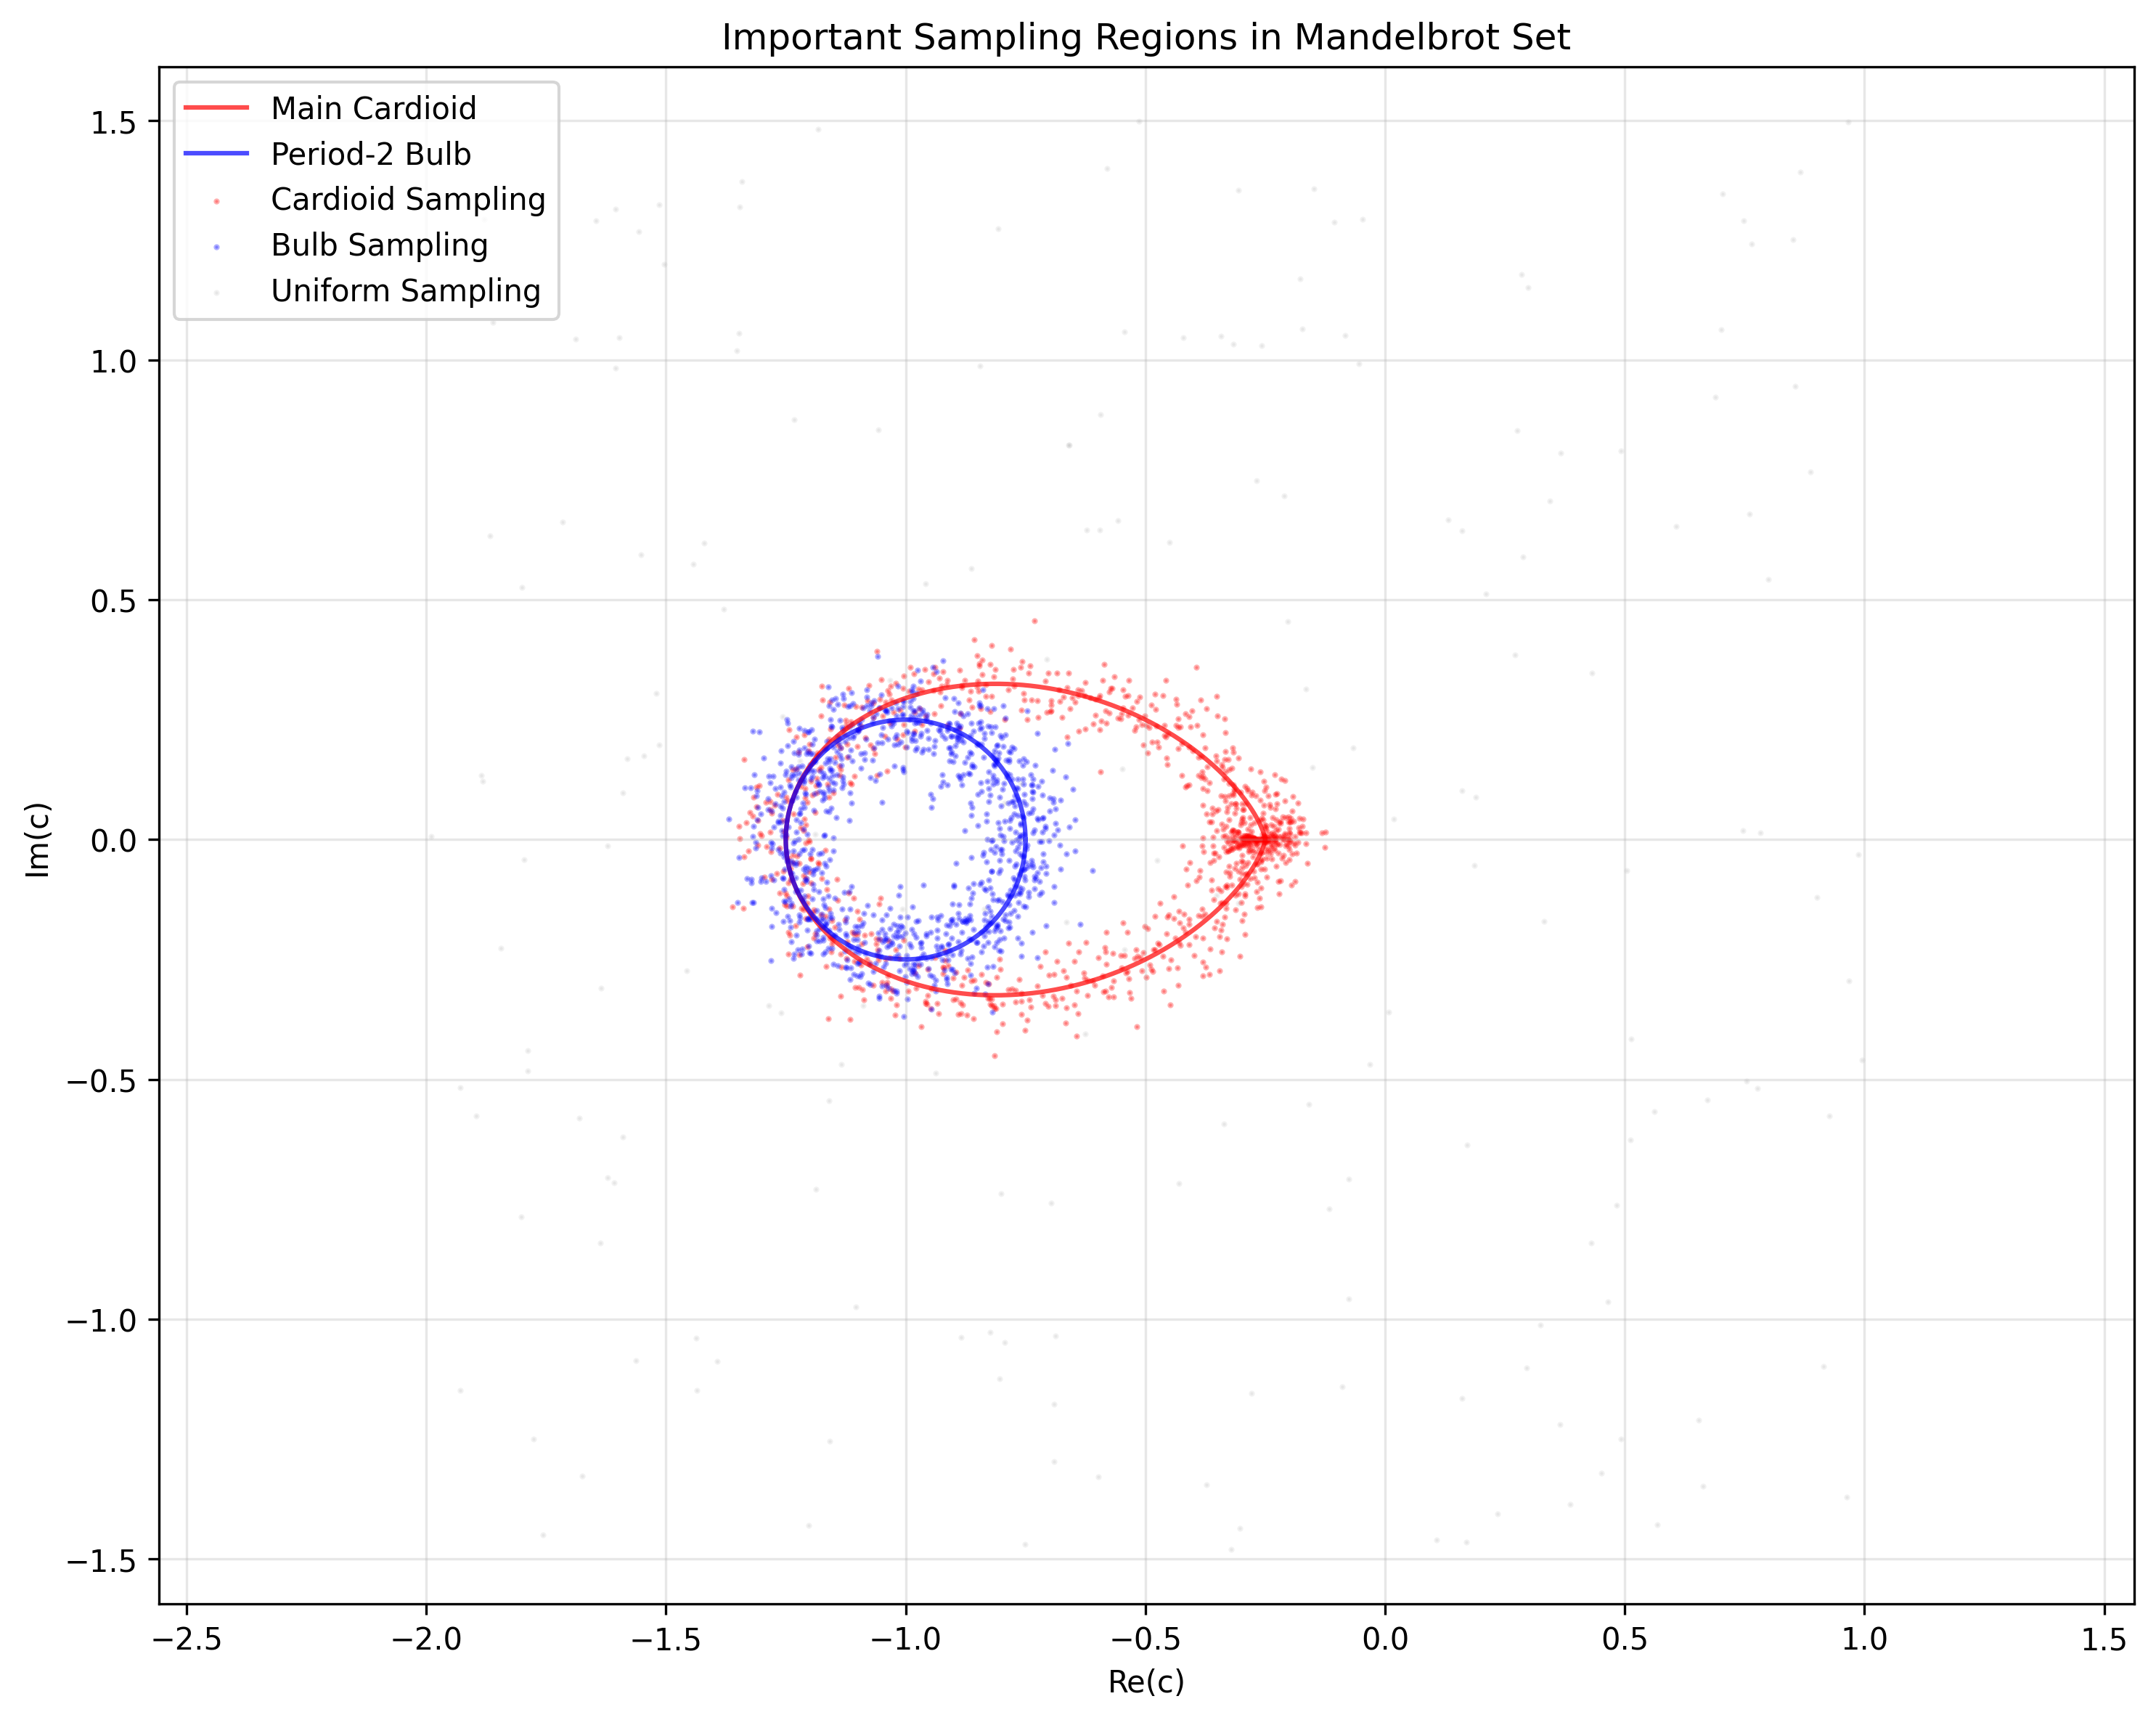

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_important_regions(size=1000):
    # Create figure
    plt.figure(figsize=(10, 8), dpi=300)
    
    # Plot main cardioid boundary
    t = np.linspace(0, 2*np.pi, 1000)
    r = 0.25 * (1 - np.cos(t))
    x = 0.25 * (np.cos(t) - 2) + r * np.cos(t)
    y = r * np.sin(t)
    plt.plot(x, y, 'r-', label='Main Cardioid', alpha=0.7)
    
    # Plot period-2 bulb (circle centered at (-1, 0) with radius 0.25)
    theta = np.linspace(0, 2*np.pi, 1000)
    x = -1 + 0.25 * np.cos(theta)
    y = 0.25 * np.sin(theta)
    plt.plot(x, y, 'b-', label='Period-2 Bulb', alpha=0.7)
    
    # Plot focused sampling regions with some noise
    # Main cardioid region
    t = np.linspace(0, 2*np.pi, size)
    r = 0.25 * (1 - np.cos(t))
    noise = np.random.normal(0, 0.05, size)
    x = 0.25 * (np.cos(t) - 2) + (r + noise) * np.cos(t)
    y = (r + noise) * np.sin(t)
    plt.scatter(x, y, c='red', s=1, alpha=0.3, label='Cardioid Sampling')
    
    # Period-2 bulb region
    theta = np.random.uniform(0, 2*np.pi, size)
    r = np.random.normal(0.25, 0.05, size)
    x = -1 + r * np.cos(theta)
    y = r * np.sin(theta)
    plt.scatter(x, y, c='blue', s=1, alpha=0.3, label='Bulb Sampling')
    
    # Add some uniform samples across the whole region
    x = np.random.uniform(-2, 1, size//5)
    y = np.random.uniform(-1.5, 1.5, size//5)
    plt.scatter(x, y, c='gray', s=1, alpha=0.1, label='Uniform Sampling')
    
    plt.title('Important Sampling Regions in Mandelbrot Set')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Create visualization with important regions
plot_important_regions()